# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from sklearn.metrics import roc_auc_score, roc_curve

# from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import optuna

from tqdm.auto import tqdm

# Read data

In [2]:
dat = pd.read_csv('../data/train.csv')
dat = dat.drop(columns=['id'])

cc_dat = pd.read_csv('../data/credit_risk_dataset.csv')

merged_dat = pd.concat([dat, cc_dat])

In [4]:
merged_dat.drop_duplicates(subset=dat.columns, keep='first', inplace=True)
merged_dat.dropna(inplace=True)

In [3]:
merged_dat.isnull().sum(), merged_dat.duplicated().sum(), merged_dat.shape

(person_age                       0
 person_income                    0
 person_home_ownership            0
 person_emp_length              895
 loan_intent                      0
 loan_grade                       0
 loan_amnt                        0
 loan_int_rate                 3116
 loan_percent_income              0
 cb_person_default_on_file        0
 cb_person_cred_hist_length       0
 loan_status                      0
 dtype: int64,
 165,
 (91226, 12))

# EDA

In [5]:
data = merged_dat.copy()

target = 'loan_status'

categorcial_features = list(merged_dat.select_dtypes(include=['object']).columns)

numerical_features = merged_dat.select_dtypes(exclude=['object']).columns
numerical_features = list(numerical_features.drop(target))

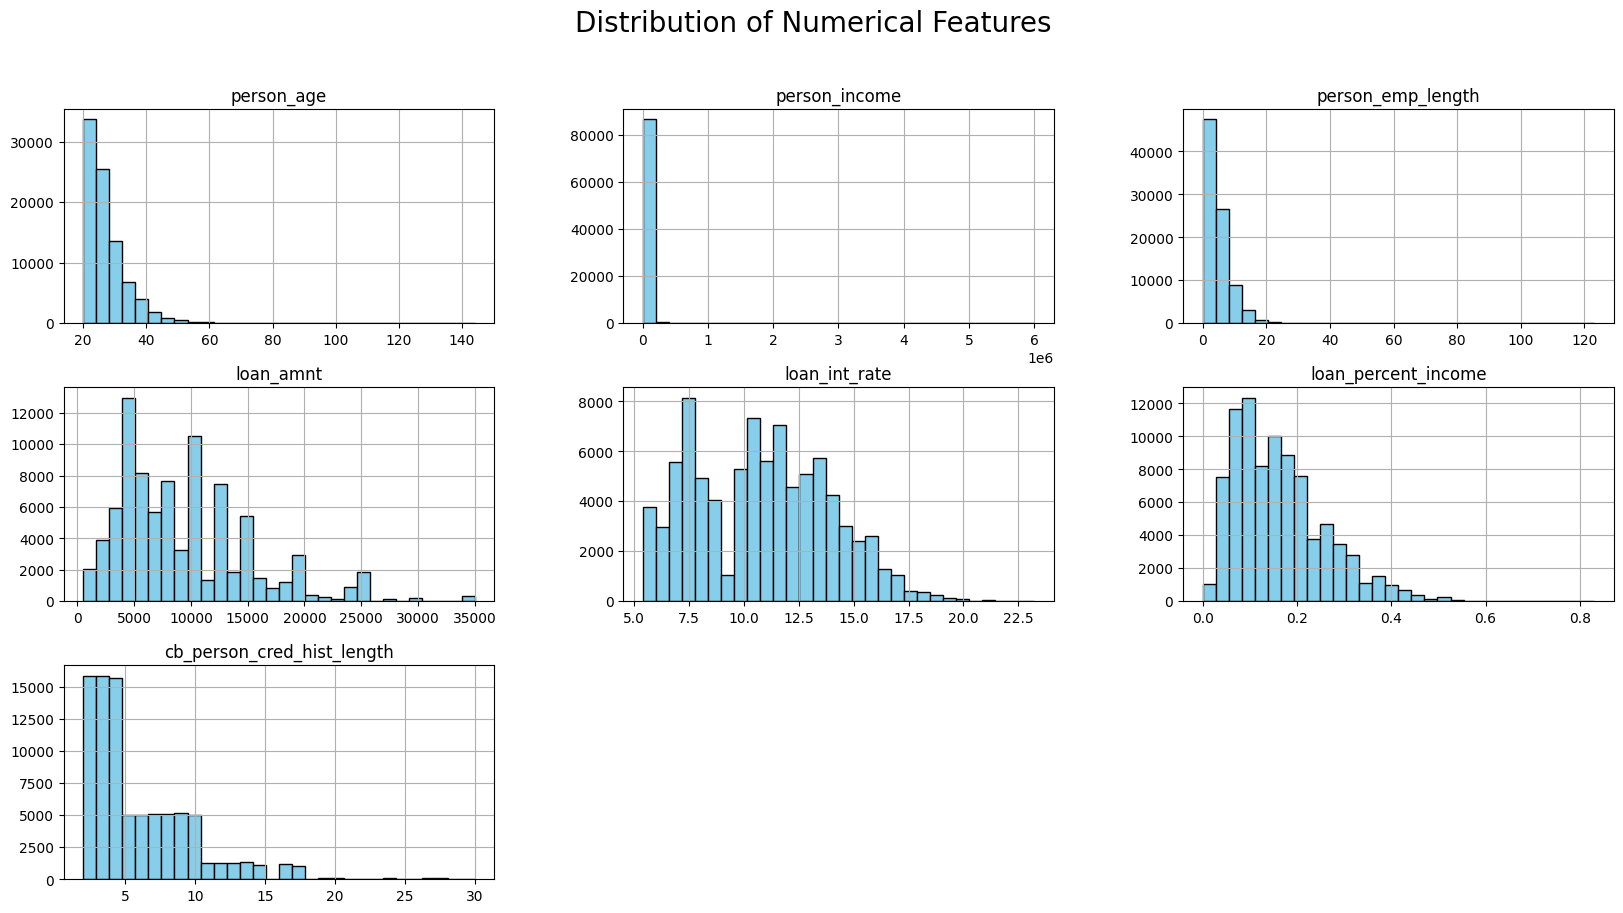

In [6]:
data[numerical_features].hist(bins=30, figsize=(20,10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=20)
plt.show()

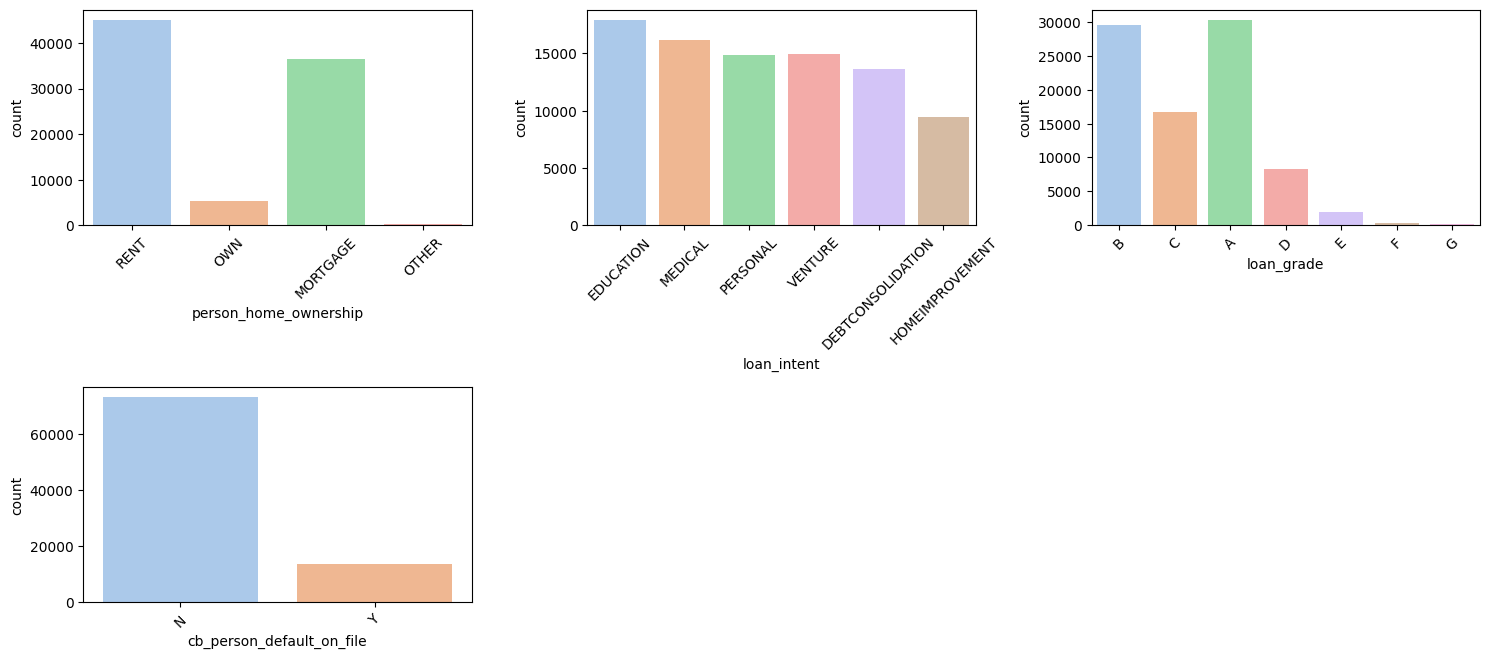

In [7]:
plt.figure(figsize=(15, 10))
for i, col in enumerate (categorcial_features, 1):
	plt.subplot(3, 3, i)
	sns.countplot(x=col, data=data, hue=col, palette='pastel', legend=False)
	plt.xticks(rotation=45)

plt.tight_layout()

# Some Processing

In [8]:
# Remove outliers using z-score
from scipy import stats
def remove_outliers_zscore(df, columns, threshold=3):
	z_scores = np.abs(stats.zscore(df[columns]))
	df = df[(z_scores < threshold).all(axis=1)]
	return df 

In [9]:
data_no_outliers = remove_outliers_zscore(data, numerical_features)

Text(0.5, 0.98, 'Distribution of Numerical Features without Outliers')

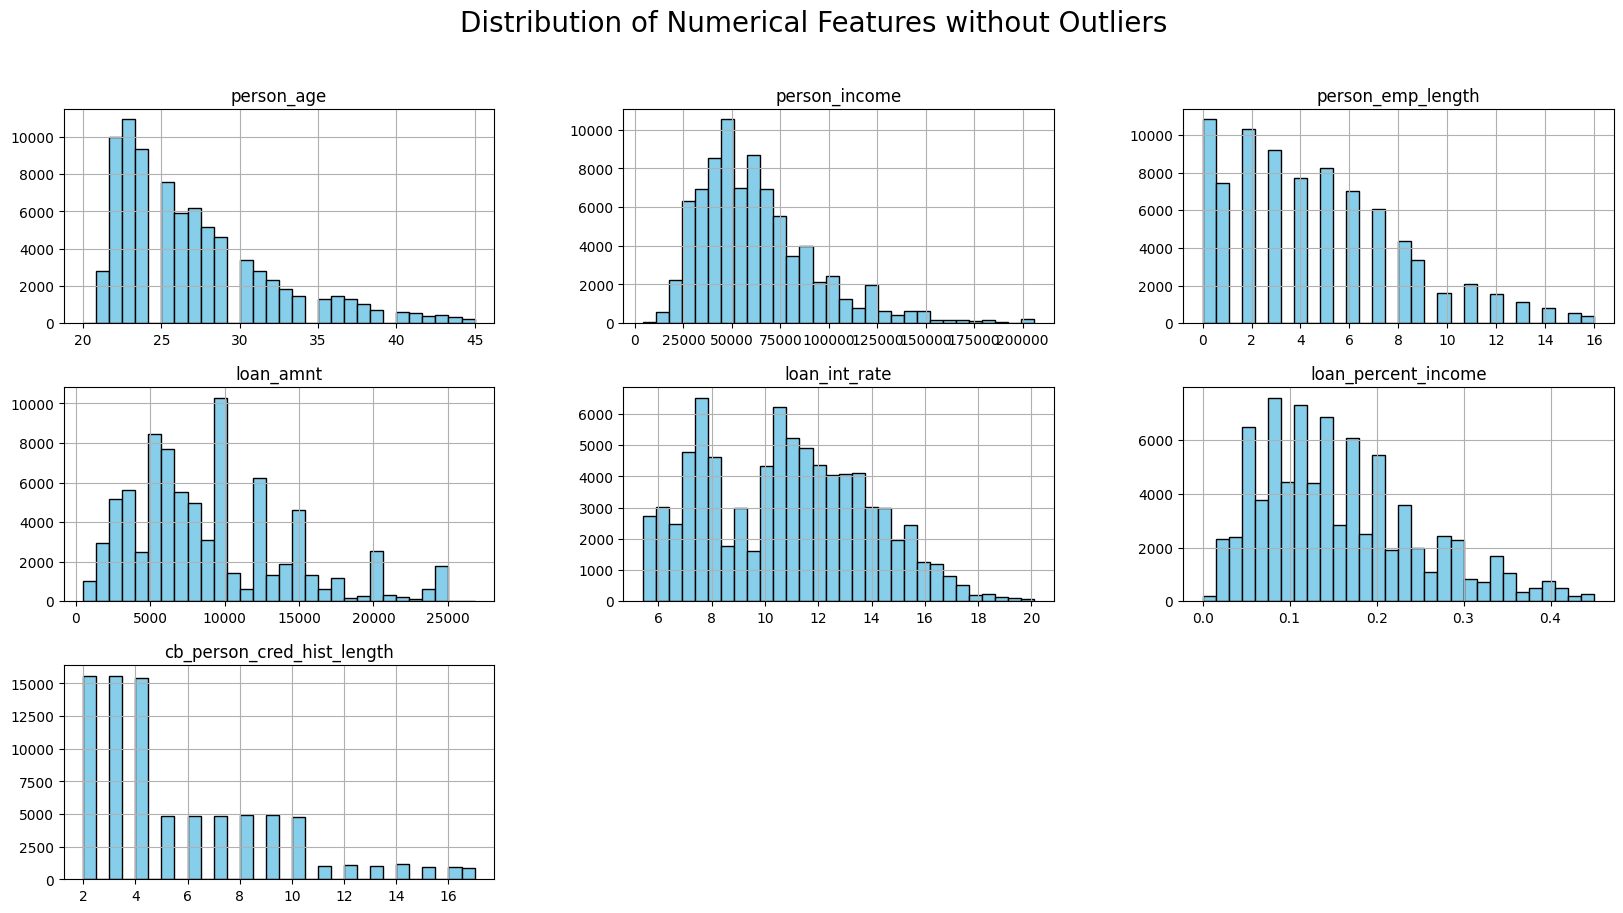

In [10]:
data_no_outliers[numerical_features].hist(bins=30, figsize=(20,10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features without Outliers', fontsize=20)

# Preprocessing

In [11]:
X = data_no_outliers.drop(columns=target)
y = data_no_outliers[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=907, stratify=y)

X_train.shape, X_test.shape

((66139, 11), (16535, 11))

In [13]:
X_train.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')

In [16]:
cat_cols = X_train.select_dtypes(include=['object']).columns
log_cols = ["person_age", "person_income", "person_emp_length", "loan_amnt"]
num_cols = X_train.select_dtypes(exclude=['object']).columns
num_cols = num_cols.drop(log_cols)

def log_transform():
	return FunctionTransformer(np.log1p)


preprocessor = ColumnTransformer(
	transformers=[
		('num', StandardScaler(), num_cols),
		('log', log_transform(), log_cols),
		('cat', OneHotEncoder(), cat_cols)
	]
)

preprocessor.fit(X_train)

X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [22]:
col_names = list(preprocessor.named_transformers_['num'].get_feature_names_out())
col_names += list(log_cols)
col_names += list(preprocessor.named_transformers_['cat'].get_feature_names_out())
col_names

['loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'person_home_ownership_MORTGAGE',
 'person_home_ownership_OTHER',
 'person_home_ownership_OWN',
 'person_home_ownership_RENT',
 'loan_intent_DEBTCONSOLIDATION',
 'loan_intent_EDUCATION',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_intent_MEDICAL',
 'loan_intent_PERSONAL',
 'loan_intent_VENTURE',
 'loan_grade_A',
 'loan_grade_B',
 'loan_grade_C',
 'loan_grade_D',
 'loan_grade_E',
 'loan_grade_F',
 'loan_grade_G',
 'cb_person_default_on_file_N',
 'cb_person_default_on_file_Y']

array([[<Axes: title={'center': 'person_age'}>,
        <Axes: title={'center': 'person_income'}>,
        <Axes: title={'center': 'person_emp_length'}>],
       [<Axes: title={'center': 'loan_amnt'}>,
        <Axes: title={'center': 'loan_int_rate'}>,
        <Axes: title={'center': 'loan_percent_income'}>],
       [<Axes: title={'center': 'cb_person_cred_hist_length'}>, <Axes: >,
        <Axes: >]], dtype=object)

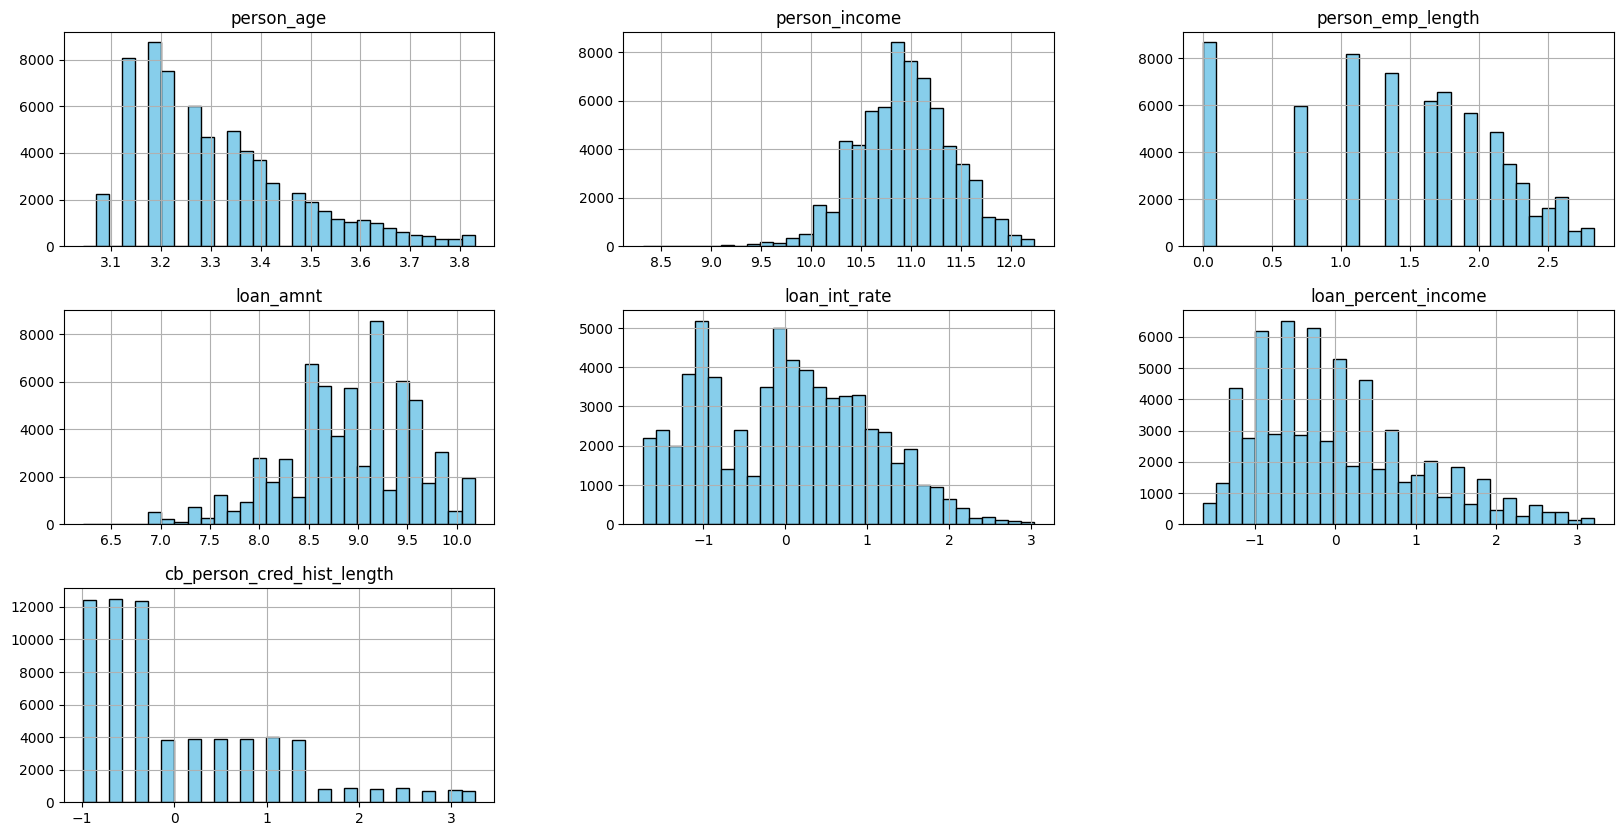

In [23]:
data_prep = pd.DataFrame(X_train_prep, columns=col_names)
data_prep[numerical_features].hist(bins=30, figsize=(20,10), color='skyblue', edgecolor='black')

# Models

In [24]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=907)

model_names = ['XGBoost', 'LightGBM', 'CatBoost']

In [38]:
def xgb_objective(trial, X, y, skf):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 10.0, log=True),
    }

    # Cross-validation with StratifiedKFold
    auc_scores = []

    for fold_idx, (train_idx, valid_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        # Training with early stopping
        bst = xgb.train(
            param, 
            dtrain, 
            evals=[(dvalid, 'validation')], 
            num_boost_round=5000, 
            early_stopping_rounds=50, 
            verbose_eval=500
        )

        # Predict probabilities
        y_pred = bst.predict(dvalid)
        auc = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc)

        # Output the AUC
        trial.report(auc, fold_idx)

    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Log the mean and std AUC
    trial.set_user_attr('std_auc', std_auc)

    return mean_auc


def optimize_xgb(X, y, skf, n_trials=200, timeout=3600*2):
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: xgb_objective(trial, X, y, skf), n_trials=n_trials, timeout=timeout)
    
    print(f"Best Score: {study.best_value}")
    print(f"Best Params: {study.best_params}")
    print(f"Best std_auc: {study.best_trial.user_attrs['std_auc']}")
    
    return study

In [34]:
X_train_prep.shape, y_train.shape

((66139, 26), (66139,))

In [39]:
xgb_study = optimize_xgb(data_prep.values, y_train, skf=skf, n_trials=200, timeout=60)

[I 2024-10-23 17:57:12,082] A new study created in memory with name: no-name-7a7a0d6a-aebd-4ada-b14d-167044c697cd
[W 2024-10-23 17:57:12,312] Trial 0 failed with parameters: {'lambda': 1.5153185828716553, 'alpha': 1.6924515994781109e-06, 'colsample_bytree': 0.9314704244522816, 'subsample': 0.6009214797013023, 'learning_rate': 0.020562082868865805, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 4.4006418690426905e-05} because of the following error: KeyError('[0, 6, 15, 31, 36, 40, 43, 45, 69, 70, 75, 81, 86, 112, 113, 123, 129, 131, 136, 153, 175, 201, 222, 227, 277, 305, 350, 362, 386, 406, 430, 435, 447, 469, 472, 473, 478, 510, 523, 535, 547, 573, 578, 606, 616, 617, 676, 730, 740, 744, 751, 769, 788, 806, 824, 839, 868, 876, 900, 907, 932, 935, 983, 986, 1019, 1032, 1076, 1079, 1086, 1129, 1131, 1135, 1137, 1202, 1219, 1251, 1258, 1260, 1269, 1320, 1321, 1323, 1342, 1375, 1422, 1433, 1442, 1491, 1503, 1517, 1520, 1542, 1561, 1564, 1567, 1595, 1604, 1612, 1613, 1620, 1624, 1655, 16

KeyError: '[0, 6, 15, 31, 36, 40, 43, 45, 69, 70, 75, 81, 86, 112, 113, 123, 129, 131, 136, 153, 175, 201, 222, 227, 277, 305, 350, 362, 386, 406, 430, 435, 447, 469, 472, 473, 478, 510, 523, 535, 547, 573, 578, 606, 616, 617, 676, 730, 740, 744, 751, 769, 788, 806, 824, 839, 868, 876, 900, 907, 932, 935, 983, 986, 1019, 1032, 1076, 1079, 1086, 1129, 1131, 1135, 1137, 1202, 1219, 1251, 1258, 1260, 1269, 1320, 1321, 1323, 1342, 1375, 1422, 1433, 1442, 1491, 1503, 1517, 1520, 1542, 1561, 1564, 1567, 1595, 1604, 1612, 1613, 1620, 1624, 1655, 1674, 1681, 1685, 1698, 1713, 1733, 1789, 1792, 1832, 1837, 1864, 1882, 1903, 1904, 1909, 1929, 1936, 1941, 1952, 1986, 1991, 2006, 2014, 2016, 2032, 2054, 2074, 2080, 2085, 2109, 2113, 2143, 2152, 2164, 2208, 2219, 2237, 2239, 2242, 2280, 2291, 2295, 2300, 2333, 2349, 2351, 2377, 2387, 2392, 2396, 2406, 2421, 2437, 2441, 2459, 2466, 2480, 2537, 2612, 2615, 2637, 2656, 2659, 2668, 2681, 2716, 2746, 2751, 2769, 2771, 2802, 2828, 2829, 2842, 2864, 2865, 2897, 2905, 2925, 2943, 2965, 3010, 3049, 3087, 3090, 3096, 3147, 3150, 3152, 3165, 3196, 3231, 3244, 3266, 3328, 3365, 3385, 3392, 3400, 3413, 3427, 3438, 3456, 3473, 3503, 3528, 3571, 3597, 3616, 3618, 3622, 3631, 3633, 3655, 3674, 3715, 3752, 3770, 3791, 3801, 3845, 3852, 3867, 3884, 3900, 3902, 3911, 3921, 3922, 3946, 3963, 3972, 4020, 4022, 4031, 4061, 4071, 4093, 4102, 4111, 4180, 4217, 4250, 4267, 4280, 4309, 4325, 4341, 4344, 4360, 4365, 4373, 4377, 4407, 4408, 4421, 4436, 4441, 4445, 4462, 4465, 4468, 4478, 4493, 4541, 4543, 4550, 4552, 4581, 4602, 4611, 4632, 4635, 4646, 4658, 4675, 4676, 4681, 4725, 4730, 4733, 4736, 4758, 4791, 4833, 4840, 4893, 4907, 4912, 4919, 4961, 4980, 4981, 4985, 5009, 5097, 5102, 5130, 5140, 5165, 5171, 5230, 5245, 5249, 5270, 5293, 5300, 5324, 5327, 5330, 5343, 5355, 5391, 5418, 5449, 5496, 5511, 5540, 5575, 5580, 5593, 5614, 5628, 5646, 5674, 5681, 5697, 5699, 5737, 5790, 5827, 5865, 5909, 5956, 5960, 5976, 5992, 6000, 6001, 6031, 6052, 6068, 6075, 6086, 6111, 6119, 6149, 6171, 6177, 6182, 6183, 6201, 6260, 6267, 6318, 6331, 6333, 6370, 6418, 6425, 6431, 6455, 6476, 6518, 6565, 6592, 6602, 6605, 6630, 6683, 6701, 6732, 6733, 6757, 6760, 6770, 6779, 6788, 6791, 6806, 6823, 6857, 6862, 6884, 6922, 6973, 6983, 6987, 6997, 7004, 7012, 7013, 7027, 7035, 7090, 7122, 7191, 7209, 7258, 7270, 7271, 7277, 7333, 7364, 7378, 7390, 7406, 7413, 7425, 7454, 7457, 7459, 7504, 7554, 7566, 7581, 7584, 7587, 7600, 7614, 7623, 7678, 7686, 7715, 7761, 7798, 7802, 7811, 7919, 7934, 7958, 7990, 8080, 8140, 8160, 8174, 8176, 8183, 8196, 8230, 8240, 8261, 8262, 8264, 8282, 8285, 8296, 8353, 8378, 8386, 8397, 8423, 8427, 8454, 8501, 8560, 8614, 8672, 8693, 8695, 8698, 8754, 8762, 8787, 8800, 8852, 8854, 8942, 8956, 8961, 8979, 9021, 9033, 9043, 9180, 9199, 9206, 9245, 9271, 9281, 9323, 9329, 9365, 9369, 9378, 9417, 9425, 9462, 9481, 9484, 9509, 9510, 9525, 9530, 9534, 9535, 9542, 9608, 9621, 9637, 9647, 9657, 9665, 9668, 9687, 9699, 9700, 9722, 9733, 9750, 9753, 9764, 9886, 9888, 9922, 9960, 9980, 10007, 10094, 10100, 10148, 10165, 10170, 10191, 10213, 10228, 10241, 10249, 10295, 10312, 10329, 10338, 10350, 10376, 10391, 10392, 10393, 10398, 10444, 10462, 10464, 10541, 10580, 10607, 10608, 10668, 10678, 10703, 10723, 10753, 10761, 10766, 10767, 10772, 10784, 10787, 10800, 10821, 10823, 10841, 10846, 10866, 10898, 10923, 10972, 10980, 10987, 11049, 11052, 11056, 11096, 11102, 11109, 11146, 11175, 11180, 11209, 11228, 11244, 11266, 11299, 11318, 11324, 11338, 11471, 11474, 11485, 11489, 11508, 11595, 11611, 11619, 11634, 11651, 11657, 11668, 11694, 11720, 11747, 11751, 11765, 11781, 11817, 11849, 11890, 11893, 11912, 11950, 11956, 11960, 11981, 11986, 11989, 12011, 12012, 12013, 12028, 12055, 12072, 12076, 12077, 12139, 12168, 12178, 12182, 12194, 12227, 12242, 12251, 12266, 12272, 12273, 12316, 12318, 12337, 12346, 12354, 12366, 12378, 12387, 12418, 12431, 12435, 12457, 12478, 12489, 12491, 12494, 12507, 12521, 12565, 12568, 12585, 12599, 12607, 12618, 12638, 12662, 12669, 12684, 12686, 12689, 12735, 12737, 12774, 12779, 12791, 12814, 12844, 12851, 12858, 12894, 12898, 12920, 12922, 12941, 12942, 12951, 12966, 12991, 12994, 12999, 13020, 13022, 13044, 13058, 13133, 13137, 13142, 13182, 13192, 13214, 13217, 13224, 13241, 13272, 13287, 13330, 13364, 13386, 13423, 13426, 13465, 13469, 13481, 13489, 13499, 13503, 13506, 13561, 13562, 13614, 13645, 13681, 13698, 13705, 13738, 13745, 13783, 13837, 13868, 13873, 13883, 13922, 14015, 14019, 14021, 14031, 14033, 14046, 14078, 14080, 14081, 14088, 14167, 14201, 14210, 14220, 14241, 14243, 14272, 14285, 14286, 14290, 14316, 14346, 14380, 14402, 14409, 14425, 14442, 14473, 14478, 14481, 14552, 14557, 14604, 14647, 14664, 14673, 14704, 14765, 14813, 14814, 14825, 14868, 14911, 14937, 15032, 15044, 15054, 15056, 15067, 15087, 15110, 15122, 15152, 15215, 15260, 15265, 15293, 15326, 15330, 15405, 15441, 15451, 15476, 15483, 15487, 15509, 15525, 15530, 15591, 15592, 15610, 15663, 15706, 15730, 15738, 15744, 15761, 15800, 15809, 15824, 15866, 15877, 15882, 15883, 15892, 15901, 15911, 15921, 15925, 15941, 15942, 15943, 15944, 15949, 15963, 15969, 15979, 16024, 16032, 16038, 16067, 16093, 16115, 16142, 16144, 16148, 16164, 16197, 16201, 16206, 16212, 16256, 16263, 16293, 16300, 16302, 16328, 16331, 16343, 16378, 16379, 16391, 16396, 16412, 16420, 16423, 16452, 16466, 16474, 16485, 16489, 16490, 16495, 16524, 16545, 16556, 16563, 16569, 16575, 16584, 16585, 16586, 16592, 16611, 16646, 16666, 16690, 16701, 16706, 16754, 16758, 16759, 16770, 16778, 16792, 16798, 16800, 16819, 16844, 16857, 16862, 16871, 16883, 16884, 16930, 16954, 16958, 16971, 17037, 17045, 17050, 17087, 17103, 17113, 17135, 17148, 17157, 17179, 17195, 17213, 17215, 17227, 17247, 17253, 17256, 17278, 17285, 17300, 17320, 17345, 17346, 17351, 17352, 17386, 17419, 17432, 17448, 17459, 17462, 17487, 17502, 17529, 17541, 17583, 17588, 17590, 17611, 17642, 17654, 17667, 17689, 17739, 17744, 17757, 17761, 17770, 17774, 17777, 17779, 17787, 17801, 17815, 17829, 17833, 17847, 17851, 17855, 17861, 17868, 17876, 17878, 17879, 17880, 17892, 17894, 17912, 17913, 17914, 17919, 17921, 17939, 17944, 17947, 17952, 17966, 17973, 17979, 17982, 17992, 18030, 18054, 18055, 18070, 18076, 18104, 18108, 18109, 18135, 18158, 18174, 18206, 18214, 18241, 18244, 18263, 18267, 18274, 18278, 18314, 18315, 18321, 18322, 18335, 18360, 18377, 18459, 18475, 18479, 18488, 18508, 18516, 18542, 18553, 18590, 18592, 18667, 18669, 18682, 18695, 18698, 18727, 18762, 18764, 18775, 18785, 18786, 18806, 18834, 18865, 18875, 18880, 18881, 18900, 18938, 18953, 18987, 19004, 19020, 19029, 19060, 19061, 19076, 19084, 19165, 19178, 19180, 19194, 19221, 19231, 19246, 19271, 19280, 19303, 19305, 19309, 19342, 19348, 19377, 19427, 19436, 19445, 19453, 19473, 19504, 19524, 19571, 19583, 19642, 19652, 19655, 19672, 19676, 19691, 19699, 19731, 19737, 19753, 19781, 19824, 19865, 19869, 19888, 19897, 19904, 19914, 19925, 19945, 19988, 20013, 20028, 20079, 20111, 20123, 20148, 20156, 20209, 20220, 20222, 20271, 20295, 20332, 20365, 20412, 20417, 20449, 20478, 20540, 20552, 20640, 20645, 20675, 20711, 20712, 20722, 20723, 20733, 20768, 20771, 20783, 20845, 20891, 20912, 20928, 20934, 20943, 20991, 20996, 20999, 21029, 21031, 21063, 21067, 21106, 21108, 21123, 21128, 21135, 21138, 21220, 21293, 21301, 21318, 21343, 21357, 21359, 21366, 21369, 21381, 21418, 21445, 21469, 21488, 21492, 21507, 21515, 21541, 21548, 21563, 21574, 21625, 21657, 21691, 21713, 21732, 21747, 21799, 21835, 21864, 21888, 21960, 21961, 21972, 21990, 22012, 22051, 22055, 22071, 22081, 22093, 22113, 22126, 22141, 22147, 22152, 22164, 22188, 22191, 22198, 22222, 22238, 22257, 22266, 22268, 22283, 22293, 22300, 22336, 22340, 22369, 22371, 22409, 22464, 22466, 22501, 22505, 22543, 22569, 22574, 22594, 22655, 22667, 22688, 22711, 22747, 22767, 22777, 22778, 22788, 22797, 22818, 22844, 22860, 22875, 22891, 22896, 22905, 22909, 22928, 23009, 23055, 23063, 23100, 23142, 23143, 23176, 23195, 23200, 23205, 23246, 23248, 23259, 23270, 23283, 23297, 23306, 23310, 23313, 23331, 23334, 23410, 23431, 23441, 23498, 23546, 23615, 23635, 23642, 23665, 23692, 23710, 23712, 23742, 23775, 23781, 23803, 23809, 23821, 23838, 23840, 23847, 23862, 23868, 23886, 23905, 23912, 23942, 24007, 24040, 24043, 24059, 24070, 24093, 24101, 24135, 24153, 24193, 24204, 24205, 24251, 24261, 24266, 24270, 24298, 24305, 24326, 24338, 24356, 24375, 24408, 24409, 24444, 24484, 24505, 24532, 24537, 24550, 24583, 24597, 24652, 24701, 24713, 24737, 24741, 24744, 24795, 24797, 24853, 24860, 24869, 24877, 24890, 24903, 24911, 24943, 24947, 24961, 24965, 24972, 25022, 25040, 25052, 25092, 25108, 25120, 25126, 25135, 25143, 25152, 25176, 25187, 25192, 25215, 25222, 25226, 25246, 25279, 25284, 25309, 25310, 25324, 25338, 25339, 25347, 25368, 25388, 25442, 25446, 25470, 25475, 25483, 25545, 25553, 25557, 25590, 25612, 25654, 25710, 25716, 25727, 25759, 25766, 25776, 25788, 25791, 25807, 25837, 25855, 25893, 25899, 25904, 25913, 25919, 25928, 25929, 25935, 25938, 25991, 26076, 26125, 26143, 26162, 26202, 26230, 26233, 26256, 26261, 26273, 26277, 26289, 26291, 26313, 26319, 26460, 26462, 26464, 26481, 26489, 26497, 26500, 26525, 26536, 26547, 26548, 26549, 26569, 26580, 26581, 26588, 26609, 26612, 26636, 26641, 26655, 26661, 26664, 26675, 26676, 26679, 26690, 26708, 26709, 26745, 26766, 26780, 26826, 26832, 26837, 26848, 26853, 26888, 26890, 26945, 26956, 26978, 27042, 27049, 27078, 27106, 27116, 27119, 27120, 27173, 27176, 27188, 27206, 27210, 27230, 27234, 27244, 27249, 27272, 27307, 27324, 27335, 27338, 27382, 27411, 27426, 27470, 27487, 27488, 27492, 27493, 27546, 27615, 27628, 27636, 27642, 27664, 27680, 27701, 27705, 27724, 27750, 27764, 27784, 27806, 27823, 27831, 27854, 27857, 27859, 27876, 27877, 27889, 27943, 27953, 27958, 27971, 28002, 28015, 28032, 28037, 28053, 28061, 28115, 28164, 28176, 28185, 28226, 28241, 28260, 28279, 28280, 28294, 28303, 28313, 28348, 28362, 28378, 28385, 28414, 28425, 28426, 28429, 28438, 28447, 28497, 28527, 28562, 28573, 28592, 28600, 28609, 28617, 28688, 28703, 28712, 28718, 28720, 28724, 28729, 28757, 28765, 28770, 28799, 28800, 28806, 28817, 28830, 28840, 28847, 28871, 28896, 28917, 28959, 28997, 28998, 29022, 29027, 29034, 29047, 29072, 29081, 29082, 29107, 29111, 29119, 29120, 29136, 29142, 29143, 29150, 29167, 29168, 29232, 29243, 29249, 29250, 29256, 29268, 29270, 29290, 29352, 29372, 29417, 29434, 29437, 29439, 29452, 29454, 29469, 29488, 29493, 29495, 29536, 29552, 29582, 29595, 29598, 29611, 29627, 29669, 29675, 29678, 29687, 29713, 29721, 29728, 29750, 29768, 29772, 29797, 29805, 29812, 29820, 29856, 29878, 29880, 29886, 29887, 29900, 29905, 29914, 29921, 29927, 29949, 29962, 29972, 29975, 29977, 29996, 30000, 30003, 30017, 30020, 30042, 30081, 30105, 30106, 30167, 30189, 30202, 30205, 30214, 30229, 30246, 30261, 30271, 30274, 30280, 30288, 30301, 30303, 30323, 30339, 30341, 30362, 30383, 30394, 30400, 30402, 30412, 30417, 30418, 30421, 30427, 30431, 30452, 30467, 30469, 30476, 30515, 30523, 30547, 30551, 30557, 30562, 30569, 30577, 30580, 30644, 30646, 30651, 30660, 30678, 30681, 30703, 30708, 30717, 30721, 30765, 30774, 30781, 30788, 30806, 30848, 30854, 30875, 30898, 30902, 30924, 30996, 30998, 31001, 31033, 31055, 31072, 31075, 31079, 31159, 31171, 31177, 31184, 31199, 31220, 31242, 31257, 31260, 31289, 31321, 31328, 31330, 31354, 31362, 31379, 31383, 31403, 31407, 31426, 31463, 31466, 31469, 31474, 31500, 31530, 31541, 31543, 31561, 31574, 31577, 31579, 31581, 31591, 31602, 31606, 31641, 31650, 31655, 31672, 31673, 31681, 31685, 31699, 31726, 31781, 31785, 31787, 31810, 31819, 31834, 31846, 31871, 31875, 31906, 31912, 31914, 31926, 31942, 31957, 31966, 31982, 32005, 32011, 32028, 32058, 32060, 32067, 32068, 32070, 32075, 32081, 32113, 32124, 32133, 32139, 32142, 32145, 32156, 32163, 32164, 32172, 32178, 32188, 32192, 32198, 32202, 32213, 32254, 32262, 32269, 32297, 32306, 32307, 32327, 32335, 32343, 32347, 32371, 32397, 32425, 32446, 32451, 32453, 32456, 32465, 32466, 32470, 32481, 32514, 32516, 32517, 32518, 32526, 32532, 32540, 32544, 32545, 32547, 32552, 32555, 32563, 32567, 32575, 32582, 32602, 32603, 32608, 32611, 32612, 32622, 32628, 32629, 32639, 32649, 32653, 32656, 32657, 32659, 32662, 32671, 32677, 32686, 32724, 32726, 32729, 32732, 32736, 32747, 32756, 32781, 32789, 32794, 32797, 32798, 32800, 32807, 32812, 32816, 32822, 32824, 32839, 32841, 32862, 32866, 32877, 32891, 32900, 32904, 32905, 32916, 32919, 32922, 32927, 32933, 32937, 32938, 32944, 32948, 32953, 32959, 32964, 32969, 32977, 32992, 33006, 33011, 33013, 33018, 33021, 33046, 33052, 33057, 33060, 33067, 33085, 33095, 33103, 33104, 33110, 33111, 33112, 33114, 33129, 33138, 33148, 33165, 33172, 33176, 33179, 33183, 33185, 33193, 33202, 33205, 33207, 33214, 33217, 33218, 33242, 33244, 33245, 33254, 33256, 33259, 33260, 33272, 33286, 33288, 33296, 33306, 33316, 33319, 33331, 33336, 33352, 33355, 33357, 33359, 33369, 33374, 33384, 33391, 33402, 33403, 33406, 33407, 33408, 33412, 33414, 33416, 33426, 33428, 33437, 33440, 33443, 33453, 33460, 33466, 33477, 33479, 33490, 33493, 33494, 33514, 33515, 33529, 33531, 33535, 33540, 33584, 33588, 33595, 33599, 33603, 33622, 33625, 33633, 33642, 33647, 33651, 33652, 33656, 33663, 33665, 33669, 33677, 33679, 33692, 33699, 33700, 33704, 33707, 33708, 33709, 33712, 33717, 33720, 33721, 33724, 33734, 33739, 33742, 33745, 33750, 33758, 33761, 33771, 33774, 33779, 33780, 33783, 33784, 33802, 33817, 33829, 33833, 33841, 33842, 33843, 33846, 33850, 33852, 33861, 33869, 33873, 33884, 33895, 33900, 33906, 33908, 33914, 33921, 33928, 33935, 33936, 33938, 33947, 33952, 33974, 33977, 33980, 33995, 34011, 34019, 34022, 34025, 34028, 34036, 34042, 34045, 34046, 34047, 34055, 34056, 34061, 34076, 34094, 34103, 34104, 34106, 34108, 34110, 34124, 34133, 34135, 34142, 34143, 34146, 34148, 34155, 34162, 34164, 34172, 34184, 34187, 34198, 34203, 34213, 34231, 34232, 34242, 34253, 34256, 34258, 34260, 34266, 34279, 34282, 34286, 34317, 34327, 34332, 34347, 34356, 34357, 34358, 34367, 34372, 34378, 34380, 34392, 34395, 34396, 34403, 34417, 34418, 34447, 34449, 34455, 34463, 34475, 34485, 34488, 34493, 34499, 34529, 34530, 34543, 34563, 34570, 34574, 34578, 34584, 34593, 34600, 34605, 34612, 34622, 34628, 34640, 34648, 34651, 34653, 34654, 34662, 34664, 34670, 34677, 34678, 34686, 34688, 34706, 34717, 34725, 34727, 34732, 34738, 34752, 34776, 34799, 34800, 34801, 34806, 34812, 34822, 34824, 34842, 34852, 34855, 34867, 34870, 34879, 34880, 34883, 34884, 34888, 34900, 34918, 34921, 34926, 34934, 34937, 34942, 34956, 34963, 34966, 34972, 34983, 34988, 35000, 35002, 35010, 35013, 35017, 35035, 35036, 35041, 35043, 35048, 35050, 35051, 35055, 35059, 35081, 35095, 35098, 35113, 35124, 35126, 35129, 35133, 35135, 35139, 35140, 35145, 35153, 35154, 35181, 35185, 35186, 35187, 35188, 35191, 35196, 35203, 35205, 35206, 35212, 35216, 35218, 35223, 35225, 35235, 35241, 35247, 35253, 35256, 35262, 35268, 35281, 35284, 35293, 35304, 35310, 35311, 35324, 35336, 35344, 35364, 35366, 35374, 35401, 35403, 35407, 35421, 35430, 35438, 35440, 35456, 35461, 35466, 35474, 35476, 35505, 35506, 35512, 35519, 35527, 35532, 35544, 35548, 35565, 35582, 35583, 35593, 35602, 35604, 35615, 35617, 35618, 35619, 35639, 35640, 35647, 35666, 35667, 35684, 35693, 35700, 35702, 35709, 35710, 35726, 35729, 35734, 35740, 35745, 35749, 35750, 35759, 35765, 35782, 35793, 35796, 35800, 35807, 35808, 35816, 35819, 35826, 35834, 35839, 35846, 35847, 35852, 35854, 35858, 35862, 35870, 35878, 35881, 35882, 35885, 35904, 35916, 35918, 35925, 35926, 35935, 35938, 35951, 35967, 35974, 35975, 35980, 36002, 36018, 36020, 36026, 36029, 36033, 36034, 36040, 36059, 36062, 36072, 36076, 36078, 36080, 36081, 36083, 36084, 36091, 36100, 36107, 36112, 36118, 36120, 36123, 36124, 36128, 36130, 36137, 36140, 36154, 36155, 36160, 36166, 36188, 36196, 36220, 36234, 36235, 36237, 36250, 36254, 36257, 36258, 36266, 36267, 36269, 36281, 36289, 36291, 36302, 36320, 36322, 36327, 36340, 36341, 36351, 36360, 36371, 36375, 36384, 36387, 36405, 36408, 36423, 36439, 36445, 36453, 36466, 36468, 36472, 36473, 36477, 36483, 36491, 36504, 36507, 36508, 36511, 36514, 36515, 36517, 36524, 36533, 36534, 36535, 36537, 36541, 36543, 36549, 36557, 36564, 36566, 36570, 36573, 36580, 36583, 36588, 36593, 36595, 36603, 36604, 36606, 36607, 36615, 36616, 36633, 36635, 36636, 36638, 36642, 36650, 36651, 36652, 36653, 36656, 36669, 36688, 36712, 36717, 36722, 36741, 36742, 36747, 36748, 36750, 36761, 36767, 36771, 36776, 36777, 36779, 36781, 36791, 36793, 36794, 36807, 36818, 36824, 36827, 36830, 36832, 36838, 36846, 36859, 36869, 36878, 36886, 36889, 36893, 36894, 36898, 36902, 36905, 36908, 36909, 36914, 36919, 36920, 36925, 36926, 36931, 36932, 36944, 36952, 36955, 36962, 36964, 36965, 36967, 36972, 36973, 36978, 36981, 36983, 36986, 36990, 36992, 37003, 37005, 37011, 37015, 37017, 37021, 37022, 37024, 37026, 37035, 37038, 37052, 37059, 37066, 37081, 37085, 37093, 37103, 37112, 37120, 37122, 37126, 37127, 37129, 37132, 37139, 37142, 37178, 37181, 37184, 37185, 37199, 37218, 37233, 37239, 37251, 37254, 37257, 37258, 37271, 37273, 37274, 37281, 37282, 37288, 37293, 37298, 37301, 37305, 37313, 37319, 37323, 37336, 37350, 37353, 37356, 37367, 37369, 37385, 37400, 37402, 37412, 37417, 37427, 37439, 37440, 37445, 37457, 37460, 37461, 37466, 37476, 37503, 37506, 37517, 37534, 37535, 37536, 37542, 37544, 37546, 37549, 37552, 37559, 37564, 37565, 37566, 37603, 37624, 37625, 37628, 37637, 37643, 37647, 37648, 37652, 37670, 37672, 37674, 37696, 37730, 37742, 37749, 37752, 37763, 37766, 37772, 37781, 37785, 37787, 37795, 37797, 37800, 37810, 37827, 37830, 37834, 37839, 37844, 37847, 37853, 37855, 37860, 37871, 37874, 37879, 37880, 37885, 37886, 37889, 37901, 37902, 37908, 37912, 37918, 37919, 37920, 37929, 37930, 37931, 37933, 37938, 37954, 37955, 37958, 37968, 37969, 37982, 37986, 37993, 37997, 38005, 38015, 38021, 38022, 38030, 38033, 38044, 38045, 38046, 38059, 38063, 38067, 38069, 38072, 38076, 38079, 38080, 38084, 38087, 38092, 38105, 38113, 38138, 38139, 38145, 38154, 38156, 38160, 38177, 38183, 38185, 38191, 38192, 38193, 38199, 38214, 38215, 38225, 38242, 38244, 38256, 38258, 38263, 38271, 38274, 38275, 38278, 38289, 38319, 38320, 38327, 38333, 38352, 38353, 38355, 38358, 38361, 38365, 38383, 38398, 38424, 38439, 38444, 38446, 38451, 38453, 38465, 38469, 38478, 38490, 38502, 38503, 38514, 38527, 38539, 38542, 38551, 38555, 38573, 38582, 38598, 38603, 38613, 38626, 38636, 38638, 38639, 38640, 38641, 38643, 38655, 38657, 38660, 38668, 38673, 38678, 38700, 38706, 38721, 38727, 38728, 38734, 38736, 38749, 38784, 38806, 38807, 38811, 38825, 38826, 38834, 38837, 38842, 38843, 38844, 38851, 38855, 38863, 38865, 38870, 38873, 38878, 38891, 38895, 38905, 38906, 38910, 38914, 38915, 38929, 38930, 38933, 38935, 38944, 38949, 38950, 38954, 38955, 38958, 38959, 38960, 38961, 38982, 38987, 38991, 38998, 38999, 39001, 39020, 39025, 39028, 39040, 39041, 39065, 39067, 39071, 39077, 39078, 39079, 39085, 39088, 39089, 39093, 39112, 39114, 39119, 39127, 39142, 39143, 39153, 39154, 39164, 39167, 39174, 39189, 39199, 39200, 39207, 39210, 39238, 39245, 39249, 39250, 39256, 39271, 39277, 39289, 39302, 39303, 39314, 39322, 39330, 39337, 39343, 39355, 39369, 39370, 39372, 39382, 39388, 39390, 39394, 39411, 39417, 39423, 39425, 39439, 39443, 39450, 39459, 39465, 39476, 39482, 39495, 39499, 39514, 39528, 39546, 39554, 39562, 39563, 39573, 39575, 39577, 39584, 39586, 39592, 39597, 39632, 39634, 39640, 39643, 39653, 39656, 39663, 39666, 39668, 39670, 39672, 39675, 39701, 39705, 39709, 39713, 39715, 39721, 39724, 39729, 39731, 39735, 39738, 39751, 39753, 39759, 39760, 39762, 39767, 39768, 39770, 39780, 39782, 39784, 39787, 39790, 39805, 39809, 39812, 39818, 39825, 39826, 39827, 39828, 39830, 39834, 39858, 39861, 39863, 39882, 39883, 39890, 39893, 39909, 39916, 39921, 39927, 39937, 39941, 39963, 39966, 39968, 39974, 39975, 39977, 39980, 39997, 40006, 40016, 40017, 40025, 40029, 40049, 40059, 40063, 40074, 40076, 40083, 40084, 40089, 40099, 40104, 40107, 40127, 40129, 40133, 40142, 40143, 40153, 40154, 40161, 40162, 40166, 40172, 40183, 40186, 40189, 40198, 40203, 40212, 40222, 40225, 40228, 40246, 40258, 40277, 40291, 40294, 40297, 40315, 40320, 40326, 40329, 40330, 40332, 40336, 40337, 40338, 40342, 40347, 40354, 40357, 40360, 40372, 40375, 40382, 40386, 40391, 40392, 40396, 40398, 40405, 40412, 40415, 40420, 40421, 40424, 40437, 40438, 40442, 40445, 40446, 40462, 40466, 40480, 40483, 40492, 40494, 40508, 40513, 40514, 40520, 40525, 40527, 40540, 40564, 40569, 40573, 40575, 40579, 40592, 40609, 40633, 40645, 40661, 40662, 40665, 40668, 40676, 40677, 40680, 40681, 40697, 40709, 40715, 40723, 40727, 40732, 40736, 40742, 40746, 40752, 40758, 40760, 40767, 40768, 40772, 40777, 40783, 40792, 40794, 40805, 40821, 40823, 40829, 40832, 40840, 40846, 40852, 40856, 40869, 40890, 40894, 40897, 40903, 40930, 40931, 40937, 40942, 40948, 40951, 40963, 40965, 40974, 40976, 40986, 40991, 40994, 41006, 41007, 41009, 41012, 41016, 41025, 41028, 41037, 41040, 41041, 41048, 41060, 41071, 41073, 41077, 41083, 41101, 41104, 41108, 41115, 41118, 41119, 41120, 41124, 41146, 41155, 41167, 41169, 41172, 41192, 41202, 41213, 41214, 41222, 41236, 41237, 41239, 41242, 41243, 41251, 41253, 41260, 41262, 41272, 41276, 41289, 41313, 41320, 41322, 41329, 41332, 41335, 41341, 41354, 41363, 41366, 41377, 41384, 41389, 41393, 41397, 41401, 41414, 41417, 41422, 41429, 41434, 41436, 41440, 41443, 41447, 41450, 41452, 41473, 41474, 41481, 41491, 41494, 41500, 41502, 41507, 41515, 41516, 41520, 41522, 41527, 41528, 41536, 41541, 41542, 41543, 41544, 41550, 41558, 41563, 41566, 41567, 41569, 41572, 41577, 41580, 41583, 41597, 41600, 41602, 41612, 41617, 41619, 41621, 41624, 41625, 41633, 41646, 41657, 41677, 41678, 41680, 41685, 41701, 41708, 41711, 41716, 41719, 41726, 41730, 41740, 41741, 41746, 41750, 41751, 41752, 41756, 41762, 41764, 41765, 41766, 41768, 41785, 41790, 41791, 41793, 41801, 41808, 41824, 41826, 41832, 41835, 41845, 41849, 41865, 41870, 41871, 41872, 41875, 41878, 41906, 41916, 41925, 41934, 41936, 41938, 41939, 41940, 41944, 41951, 41953, 41955, 41960, 41961, 41962, 41964, 41970, 41996, 42000, 42001, 42022, 42025, 42027, 42031, 42044, 42053, 42055, 42063, 42065, 42070, 42076, 42083, 42088, 42093, 42100, 42103, 42115, 42127, 42131, 42133, 42141, 42148, 42152, 42153, 42157, 42159, 42164, 42169, 42171, 42194, 42196, 42198, 42205, 42212, 42219, 42221, 42222, 42223, 42232, 42235, 42241, 42247, 42256, 42257, 42266, 42276, 42287, 42300, 42307, 42311, 42317, 42330, 42344, 42349, 42351, 42354, 42373, 42398, 42403, 42410, 42411, 42429, 42431, 42436, 42442, 42444, 42447, 42453, 42482, 42520, 42524, 42526, 42527, 42542, 42544, 42547, 42548, 42558, 42562, 42564, 42574, 42578, 42586, 42587, 42594, 42597, 42599, 42608, 42613, 42616, 42622, 42624, 42629, 42643, 42646, 42655, 42656, 42658, 42662, 42669, 42675, 42677, 42678, 42680, 42681, 42697, 42704, 42705, 42708, 42710, 42714, 42717, 42722, 42729, 42730, 42747, 42751, 42753, 42757, 42759, 42762, 42774, 42788, 42795, 42798, 42801, 42811, 42818, 42831, 42833, 42843, 42846, 42853, 42855, 42863, 42865, 42867, 42876, 42880, 42885, 42896, 42902, 42915, 42920, 42923, 42931, 42932, 42939, 42941, 42962, 42964, 42978, 42986, 42994, 42995, 42996, 43001, 43002, 43004, 43026, 43074, 43075, 43082, 43088, 43090, 43095, 43096, 43117, 43120, 43123, 43124, 43125, 43130, 43137, 43140, 43144, 43153, 43174, 43178, 43192, 43194, 43195, 43210, 43219, 43226, 43228, 43231, 43232, 43235, 43243, 43244, 43256, 43257, 43265, 43267, 43268, 43273, 43281, 43288, 43292, 43306, 43310, 43332, 43335, 43338, 43358, 43361, 43363, 43379, 43387, 43396, 43416, 43433, 43435, 43437, 43446, 43457, 43472, 43477, 43502, 43505, 43509, 43514, 43518, 43520, 43534, 43535, 43539, 43542, 43561, 43562, 43563, 43566, 43606, 43611, 43615, 43624, 43626, 43627, 43628, 43644, 43646, 43668, 43675, 43678, 43682, 43684, 43685, 43696, 43707, 43709, 43713, 43720, 43726, 43734, 43750, 43759, 43768, 43771, 43780, 43785, 43798, 43806, 43808, 43815, 43831, 43836, 43841, 43856, 43864, 43869, 43870, 43874, 43877, 43883, 43884, 43885, 43901, 43904, 43908, 43909, 43915, 43916, 43917, 43918, 43924, 43927, 43929, 43930, 43934, 43951, 43956, 43961, 43966, 43993, 44002, 44014, 44017, 44025, 44031, 44034, 44043, 44046, 44058, 44069, 44074, 44080, 44091, 44092, 44094, 44101, 44106, 44107, 44116, 44117, 44118, 44119, 44121, 44124, 44134, 44139, 44153, 44154, 44157, 44158, 44164, 44167, 44181, 44183, 44184, 44185, 44187, 44188, 44189, 44190, 44204, 44206, 44208, 44210, 44212, 44216, 44218, 44220, 44227, 44230, 44231, 44234, 44239, 44254, 44262, 44264, 44265, 44267, 44277, 44279, 44285, 44289, 44299, 44305, 44306, 44308, 44309, 44312, 44313, 44320, 44326, 44327, 44336, 44345, 44348, 44351, 44354, 44379, 44386, 44393, 44395, 44404, 44405, 44415, 44419, 44426, 44429, 44435, 44463, 44466, 44467, 44476, 44478, 44481, 44498, 44509, 44528, 44531, 44533, 44539, 44542, 44548, 44558, 44564, 44570, 44571, 44573, 44575, 44581, 44583, 44589, 44591, 44599, 44606, 44607, 44619, 44624, 44637, 44647, 44657, 44658, 44661, 44678, 44684, 44686, 44691, 44694, 44695, 44706, 44710, 44714, 44718, 44719, 44720, 44725, 44727, 44729, 44737, 44756, 44762, 44771, 44783, 44795, 44796, 44799, 44801, 44804, 44809, 44813, 44821, 44823, 44837, 44838, 44840, 44845, 44846, 44851, 44857, 44865, 44867, 44869, 44870, 44871, 44872, 44873, 44874, 44878, 44881, 44882, 44883, 44885, 44890, 44917, 44924, 44925, 44927, 44930, 44931, 44944, 44953, 44957, 44958, 44962, 44973, 44975, 44976, 44977, 44989, 44996, 45010, 45017, 45026, 45029, 45033, 45036, 45039, 45061, 45066, 45069, 45074, 45082, 45089, 45091, 45093, 45109, 45111, 45120, 45125, 45126, 45129, 45131, 45142, 45150, 45157, 45158, 45165, 45168, 45170, 45171, 45177, 45180, 45182, 45199, 45200, 45204, 45210, 45227, 45234, 45235, 45236, 45239, 45257, 45265, 45270, 45284, 45289, 45293, 45297, 45300, 45301, 45315, 45319, 45322, 45325, 45327, 45328, 45353, 45354, 45359, 45363, 45374, 45384, 45387, 45389, 45396, 45405, 45417, 45419, 45426, 45430, 45431, 45442, 45449, 45458, 45464, 45471, 45472, 45474, 45475, 45490, 45494, 45496, 45504, 45505, 45508, 45512, 45514, 45515, 45516, 45520, 45523, 45524, 45535, 45536, 45549, 45550, 45551, 45560, 45576, 45587, 45593, 45594, 45595, 45611, 45627, 45633, 45640, 45644, 45645, 45651, 45652, 45660, 45668, 45670, 45676, 45680, 45686, 45694, 45695, 45697, 45723, 45740, 45741, 45745, 45746, 45752, 45756, 45772, 45778, 45782, 45783, 45788, 45794, 45813, 45820, 45824, 45834, 45839, 45840, 45843, 45857, 45858, 45864, 45884, 45885, 45889, 45895, 45898, 45909, 45910, 45923, 45928, 45933, 45935, 45937, 45948, 45949, 45952, 45959, 45967, 45972, 45985, 45986, 45990, 45991, 45993, 45997, 46007, 46010, 46038, 46043, 46044, 46056, 46065, 46070, 46075, 46079, 46080, 46082, 46084, 46085, 46087, 46107, 46110, 46121, 46128, 46133, 46138, 46143, 46145, 46151, 46154, 46156, 46165, 46166, 46182, 46189, 46193, 46196, 46206, 46209, 46221, 46230, 46236, 46240, 46256, 46257, 46261, 46262, 46263, 46275, 46288, 46289, 46295, 46305, 46309, 46318, 46324, 46328, 46329, 46330, 46335, 46337, 46359, 46362, 46373, 46382, 46390, 46397, 46398, 46399, 46403, 46406, 46411, 46416, 46419, 46429, 46434, 46440, 46442, 46447, 46452, 46454, 46459, 46464, 46466, 46472, 46479, 46482, 46494, 46497, 46504, 46508, 46509, 46512, 46521, 46526, 46531, 46535, 46553, 46555, 46562, 46564, 46571, 46595, 46599, 46606, 46609, 46612, 46619, 46622, 46635, 46637, 46643, 46646, 46648, 46655, 46671, 46675, 46680, 46684, 46692, 46698, 46700, 46702, 46710, 46716, 46725, 46728, 46738, 46739, 46740, 46741, 46762, 46765, 46776, 46777, 46785, 46791, 46797, 46813, 46817, 46818, 46826, 46830, 46848, 46850, 46853, 46856, 46858, 46859, 46869, 46874, 46879, 46886, 46893, 46896, 46899, 46902, 46904, 46915, 46919, 46921, 46933, 46934, 46937, 46950, 46952, 46985, 46986, 47001, 47011, 47013, 47029, 47046, 47053, 47071, 47073, 47082, 47087, 47088, 47098, 47102, 47108, 47120, 47130, 47135, 47139, 47145, 47147, 47148, 47155, 47158, 47175, 47184, 47188, 47189, 47190, 47193, 47205, 47208, 47214, 47224, 47235, 47250, 47259, 47265, 47267, 47284, 47287, 47304, 47307, 47308, 47311, 47313, 47315, 47320, 47336, 47345, 47346, 47348, 47349, 47356, 47361, 47363, 47364, 47366, 47368, 47380, 47381, 47383, 47394, 47408, 47410, 47429, 47436, 47442, 47446, 47454, 47457, 47466, 47486, 47490, 47495, 47513, 47532, 47538, 47540, 47542, 47556, 47560, 47576, 47579, 47581, 47587, 47588, 47597, 47609, 47610, 47612, 47618, 47626, 47627, 47637, 47645, 47647, 47649, 47659, 47663, 47667, 47672, 47682, 47690, 47702, 47704, 47705, 47710, 47713, 47746, 47752, 47760, 47762, 47774, 47779, 47782, 47786, 47793, 47798, 47801, 47803, 47812, 47818, 47825, 47848, 47850, 47853, 47859, 47862, 47870, 47873, 47876, 47896, 47901, 47904, 47908, 47911, 47917, 47924, 47926, 47941, 47943, 47944, 47967, 47972, 47974, 47975, 47977, 47983, 47988, 48015, 48020, 48023, 48025, 48026, 48029, 48036, 48041, 48044, 48045, 48046, 48057, 48069, 48071, 48077, 48078, 48094, 48098, 48099, 48100, 48112, 48118, 48122, 48126, 48136, 48137, 48139, 48141, 48145, 48147, 48151, 48154, 48163, 48164, 48166, 48168, 48172, 48173, 48175, 48178, 48183, 48187, 48193, 48196, 48206, 48209, 48211, 48213, 48218, 48228, 48233, 48236, 48245, 48251, 48269, 48279, 48283, 48286, 48287, 48289, 48290, 48291, 48294, 48296, 48297, 48298, 48300, 48303, 48314, 48320, 48324, 48326, 48327, 48328, 48333, 48346, 48349, 48353, 48356, 48364, 48377, 48387, 48388, 48392, 48400, 48403, 48414, 48416, 48417, 48418, 48422, 48428, 48433, 48437, 48447, 48450, 48458, 48469, 48478, 48479, 48481, 48501, 48508, 48509, 48511, 48515, 48520, 48523, 48527, 48530, 48539, 48560, 48566, 48574, 48586, 48594, 48604, 48610, 48625, 48628, 48644, 48652, 48658, 48663, 48665, 48668, 48674, 48681, 48683, 48685, 48700, 48704, 48712, 48720, 48723, 48729, 48735, 48736, 48737, 48740, 48747, 48748, 48749, 48750, 48767, 48771, 48781, 48786, 48809, 48818, 48825, 48833, 48849, 48850, 48862, 48872, 48892, 48905, 48906, 48908, 48909, 48910, 48921, 48922, 48930, 48935, 48943, 48944, 48952, 48960, 48963, 48965, 48967, 48970, 48971, 48991, 49007, 49009, 49010, 49028, 49041, 49046, 49052, 49054, 49056, 49059, 49066, 49068, 49069, 49070, 49072, 49084, 49097, 49107, 49112, 49116, 49119, 49122, 49129, 49130, 49134, 49139, 49149, 49153, 49154, 49155, 49158, 49161, 49165, 49166, 49169, 49172, 49176, 49179, 49182, 49188, 49189, 49192, 49193, 49195, 49205, 49208, 49212, 49224, 49234, 49238, 49240, 49243, 49244, 49246, 49247, 49248, 49252, 49280, 49281, 49286, 49296, 49300, 49305, 49313, 49321, 49325, 49330, 49341, 49342, 49353, 49354, 49357, 49368, 49371, 49379, 49385, 49386, 49400, 49404, 49408, 49413, 49418, 49427, 49433, 49440, 49467, 49493, 49502, 49505, 49518, 49527, 49534, 49539, 49543, 49544, 49547, 49552, 49564, 49571, 49597, 49616, 49617, 49620, 49627, 49631, 49643, 49653, 49668, 49678, 49692, 49693, 49699, 49710, 49723, 49730, 49753, 49757, 49758, 49762, 49763, 49769, 49776, 49777, 49794, 49798, 49800, 49804, 49808, 49811, 49812, 49814, 49818, 49822, 49824, 49826, 49828, 49831, 49844, 49847, 49852, 49853, 49861, 49869, 49879, 49880, 49881, 49883, 49887, 49890, 49891, 49894, 49901, 49902, 49912, 49918, 49928, 49929, 49934, 49935, 49938, 49949, 49951, 49954, 49958, 49964, 49968, 49974, 49988, 49989, 49991, 49995, 50004, 50012, 50035, 50039, 50041, 50049, 50051, 50053, 50064, 50070, 50074, 50076, 50078, 50089, 50094, 50105, 50111, 50118, 50122, 50128, 50138, 50141, 50150, 50151, 50155, 50168, 50181, 50190, 50194, 50198, 50204, 50213, 50217, 50221, 50223, 50226, 50232, 50257, 50259, 50266, 50267, 50269, 50293, 50297, 50298, 50299, 50305, 50312, 50321, 50322, 50324, 50332, 50341, 50344, 50348, 50370, 50373, 50374, 50383, 50393, 50400, 50406, 50408, 50417, 50423, 50424, 50431, 50453, 50457, 50460, 50465, 50481, 50484, 50486, 50503, 50504, 50511, 50515, 50517, 50518, 50526, 50530, 50536, 50540, 50552, 50559, 50565, 50580, 50593, 50604, 50612, 50624, 50632, 50636, 50643, 50644, 50649, 50652, 50660, 50673, 50682, 50686, 50689, 50694, 50698, 50700, 50702, 50716, 50722, 50725, 50736, 50745, 50753, 50758, 50761, 50773, 50779, 50784, 50793, 50796, 50799, 50813, 50814, 50827, 50830, 50838, 50843, 50845, 50848, 50862, 50871, 50876, 50877, 50887, 50891, 50895, 50900, 50909, 50920, 50922, 50926, 50940, 50941, 50947, 50950, 50958, 50961, 50964, 50972, 50973, 50978, 50980, 50986, 50988, 51005, 51010, 51021, 51023, 51024, 51025, 51026, 51027, 51030, 51032, 51034, 51044, 51045, 51055, 51064, 51065, 51070, 51071, 51079, 51105, 51110, 51111, 51120, 51129, 51132, 51135, 51137, 51140, 51144, 51145, 51153, 51155, 51160, 51167, 51172, 51173, 51174, 51183, 51184, 51194, 51195, 51209, 51210, 51211, 51226, 51230, 51231, 51237, 51239, 51243, 51244, 51252, 51255, 51258, 51273, 51279, 51283, 51286, 51295, 51296, 51297, 51299, 51303, 51308, 51324, 51326, 51331, 51346, 51351, 51352, 51358, 51362, 51368, 51375, 51380, 51384, 51393, 51394, 51406, 51429, 51430, 51433, 51438, 51441, 51447, 51451, 51459, 51462, 51483, 51495, 51503, 51513, 51516, 51524, 51533, 51537, 51539, 51546, 51551, 51557, 51558, 51560, 51561, 51565, 51571, 51578, 51582, 51584, 51589, 51593, 51601, 51605, 51606, 51610, 51614, 51622, 51633, 51647, 51651, 51652, 51656, 51659, 51661, 51666, 51670, 51673, 51689, 51702, 51703, 51717, 51735, 51740, 51744, 51758, 51768, 51769, 51771, 51772, 51773, 51776, 51779, 51781, 51786, 51796, 51800, 51805, 51806, 51808, 51811, 51812, 51825, 51827, 51829, 51832, 51834, 51836, 51851, 51856, 51865, 51882, 51883, 51889, 51891, 51893, 51897, 51899, 51911, 51913, 51919, 51931, 51934, 51944, 51953, 51963, 52001, 52002, 52005, 52018, 52026, 52029, 52050, 52052, 52059, 52068, 52074, 52079, 52081, 52083, 52086, 52089, 52096, 52100, 52110, 52111, 52112, 52119, 52125, 52134, 52148, 52150, 52156, 52161, 52162, 52187, 52192, 52197, 52210, 52214, 52222, 52223, 52224, 52228, 52231, 52246, 52254, 52258, 52264, 52280, 52281, 52282, 52288, 52293, 52298, 52299, 52302, 52307, 52314, 52317, 52322, 52334, 52335, 52340, 52353, 52354, 52355, 52364, 52371, 52372, 52377, 52390, 52391, 52397, 52422, 52429, 52430, 52431, 52432, 52438, 52441, 52444, 52445, 52483, 52538, 52551, 52567, 52578, 52582, 52597, 52598, 52601, 52614, 52617, 52621, 52622, 52624, 52634, 52637, 52640, 52655, 52657, 52666, 52673, 52674, 52675, 52677, 52719, 52721, 52727, 52731, 52758, 52759, 52768, 52774, 52784, 52801, 52820, 52832, 52844, 52853, 52854, 52855, 52867, 52872, 52892, 52893, 52897, 52902, 52903, 52916, 52917, 52920, 52925, 52928, 52932, 52937, 52940, 52941, 52945, 52951, 52953, 52961, 52967, 52973, 52977, 52979, 52982, 52983, 53008, 53013, 53021, 53034, 53035, 53037, 53039, 53051, 53062, 53096, 53098, 53110, 53118, 53122, 53123, 53125, 53132, 53139, 53147, 53156, 53180, 53188, 53189, 53193, 53198, 53203, 53215, 53219, 53225, 53231, 53236, 53239, 53253, 53269, 53272, 53290, 53291, 53295, 53297, 53305, 53312, 53313, 53317, 53320, 53321, 53325, 53331, 53334, 53344, 53367, 53379, 53403, 53404, 53409, 53411, 53412, 53420, 53422, 53423, 53426, 53436, 53456, 53472, 53481, 53484, 53486, 53487, 53494, 53497, 53503, 53513, 53515, 53522, 53538, 53547, 53549, 53555, 53566, 53568, 53571, 53575, 53578, 53581, 53583, 53590, 53600, 53613, 53619, 53625, 53629, 53631, 53633, 53635, 53647, 53654, 53655, 53658, 53673, 53675, 53678, 53679, 53691, 53694, 53699, 53709, 53715, 53716, 53724, 53725, 53740, 53741, 53743, 53746, 53757, 53758, 53759, 53762, 53772, 53778, 53780, 53784, 53785, 53789, 53791, 53794, 53796, 53797, 53807, 53826, 53832, 53841, 53847, 53857, 53859, 53863, 53878, 53886, 53893, 53916, 53935, 53942, 53946, 53949, 53957, 53960, 53964, 53968, 53991, 53995, 54023, 54027, 54028, 54031, 54034, 54041, 54043, 54051, 54052, 54056, 54068, 54092, 54099, 54109, 54115, 54120, 54136, 54147, 54158, 54159, 54160, 54178, 54195, 54218, 54220, 54223, 54224, 54237, 54243, 54244, 54246, 54253, 54261, 54263, 54275, 54281, 54283, 54285, 54286, 54295, 54296, 54299, 54301, 54304, 54307, 54310, 54314, 54316, 54320, 54323, 54324, 54336, 54344, 54351, 54356, 54363, 54366, 54369, 54394, 54407, 54418, 54425, 54433, 54437, 54443, 54445, 54446, 54448, 54452, 54453, 54454, 54456, 54463, 54480, 54483, 54488, 54493, 54497, 54498, 54501, 54504, 54511, 54516, 54526, 54530, 54534, 54570, 54573, 54583, 54594, 54595, 54597, 54600, 54604, 54634, 54635, 54641, 54655, 54660, 54669, 54670, 54671, 54689, 54696, 54705, 54717, 54720, 54723, 54726, 54735, 54742, 54743, 54747, 54749, 54753, 54762, 54764, 54765, 54768, 54771, 54778, 54780, 54785, 54787, 54796, 54797, 54804, 54805, 54806, 54811, 54815, 54817, 54821, 54823, 54824, 54831, 54832, 54842, 54846, 54859, 54863, 54869, 54873, 54876, 54881, 54885, 54896, 54906, 54907, 54912, 54916, 54924, 54937, 54942, 54949, 54951, 54952, 54955, 54962, 54963, 54964, 54965, 54971, 54972, 54973, 54974, 54977, 54980, 54984, 54996, 55001, 55002, 55012, 55018, 55022, 55038, 55042, 55044, 55046, 55049, 55062, 55065, 55072, 55078, 55082, 55083, 55093, 55097, 55107, 55111, 55118, 55121, 55123, 55125, 55126, 55129, 55135, 55142, 55150, 55158, 55171, 55174, 55177, 55178, 55198, 55202, 55205, 55210, 55233, 55241, 55255, 55262, 55272, 55274, 55280, 55284, 55288, 55291, 55292, 55295, 55307, 55311, 55324, 55328, 55332, 55347, 55358, 55370, 55378, 55385, 55390, 55392, 55399, 55401, 55405, 55408, 55423, 55424, 55428, 55431, 55435, 55456, 55461, 55477, 55496, 55500, 55504, 55510, 55536, 55544, 55546, 55560, 55565, 55573, 55579, 55582, 55585, 55592, 55593, 55595, 55614, 55615, 55620, 55661, 55671, 55679, 55682, 55683, 55693, 55706, 55711, 55718, 55723, 55725, 55729, 55730, 55741, 55747, 55748, 55756, 55761, 55762, 55763, 55771, 55777, 55780, 55783, 55785, 55786, 55789, 55792, 55799, 55807, 55812, 55822, 55824, 55828, 55834, 55838, 55845, 55847, 55864, 55867, 55875, 55877, 55901, 55913, 55915, 55920, 55921, 55926, 55928, 55938, 55940, 55942, 55945, 55951, 55957, 55958, 55967, 55972, 55977, 55988, 55995, 55999, 56004, 56012, 56018, 56020, 56026, 56042, 56045, 56047, 56059, 56060, 56062, 56064, 56069, 56078, 56083, 56086, 56091, 56093, 56095, 56105, 56107, 56108, 56109, 56110, 56117, 56126, 56132, 56135, 56139, 56144, 56145, 56152, 56153, 56159, 56162, 56169, 56175, 56176, 56184, 56189, 56192, 56193, 56204, 56222, 56226, 56233, 56236, 56240, 56256, 56267, 56269, 56278, 56288, 56301, 56302, 56308, 56323, 56327, 56328, 56332, 56338, 56348, 56350, 56351, 56356, 56363, 56381, 56388, 56396, 56408, 56414, 56424, 56441, 56448, 56473, 56479, 56491, 56504, 56517, 56520, 56524, 56534, 56536, 56541, 56545, 56553, 56558, 56567, 56586, 56603, 56610, 56613, 56621, 56625, 56638, 56645, 56655, 56665, 56669, 56670, 56671, 56679, 56682, 56683, 56686, 56688, 56690, 56698, 56700, 56704, 56705, 56706, 56713, 56716, 56718, 56722, 56724, 56727, 56761, 56764, 56766, 56783, 56796, 56798, 56800, 56805, 56807, 56809, 56823, 56825, 56828, 56855, 56862, 56867, 56869, 56872, 56875, 56876, 56884, 56885, 56887, 56888, 56894, 56895, 56896, 56900, 56910, 56911, 56914, 56916, 56920, 56923, 56924, 56926, 56927, 56930, 56932, 56934, 56946, 56951, 56953, 56960, 56961, 56970, 56972, 56978, 56984, 56985, 56987, 57004, 57014, 57019, 57020, 57021, 57023, 57025, 57031, 57035, 57036, 57038, 57040, 57041, 57051, 57053, 57061, 57064, 57069, 57075, 57084, 57089, 57106, 57108, 57109, 57110, 57115, 57120, 57125, 57133, 57142, 57144, 57145, 57159, 57171, 57174, 57177, 57186, 57193, 57205, 57211, 57215, 57223, 57231, 57235, 57237, 57248, 57255, 57257, 57271, 57272, 57286, 57291, 57292, 57302, 57307, 57308, 57316, 57318, 57334, 57358, 57360, 57366, 57367, 57370, 57371, 57379, 57380, 57381, 57385, 57388, 57393, 57396, 57397, 57399, 57401, 57424, 57431, 57434, 57435, 57441, 57455, 57461, 57463, 57477, 57480, 57487, 57490, 57493, 57498, 57501, 57507, 57508, 57513, 57519, 57522, 57524, 57533, 57541, 57551, 57556, 57561, 57562, 57565, 57573, 57579, 57599, 57600, 57602, 57606, 57610, 57615, 57628, 57636, 57641, 57648, 57663, 57674, 57676, 57684, 57688, 57693, 57699, 57706, 57709, 57717, 57722, 57727, 57735, 57736, 57741, 57743, 57746, 57753, 57754, 57759, 57760, 57767, 57768, 57778, 57780, 57781, 57787, 57790, 57794, 57799, 57808, 57824, 57825, 57829, 57831, 57833, 57837, 57841, 57844, 57847, 57849, 57857, 57876, 57884, 57895, 57897, 57899, 57927, 57928, 57933, 57946, 57953, 57967, 57969, 57976, 57978, 57990, 57992, 57999, 58001, 58002, 58005, 58006, 58014, 58023, 58028, 58035, 58043, 58045, 58046, 58048, 58054, 58056, 58061, 58063, 58065, 58072, 58073, 58087, 58093, 58100, 58102, 58122, 58123, 58130, 58132, 58147, 58156, 58165, 58170, 58180, 58189, 58190, 58195, 58197, 58205, 58211, 58218, 58220, 58221, 58230, 58232, 58235, 58236, 58237, 58245, 58256, 58259, 58260, 58264, 58266, 58271, 58289, 58295, 58298, 58307, 58310, 58311, 58320, 58321, 58326, 58328, 58338, 58349, 58355, 58362, 58369, 58371, 58372, 58374, 58376, 58379, 58380, 58391, 58397, 58399, 58404, 58407, 58410, 58413, 58419, 58420, 58422, 58424, 58432, 58436, 58453, 58460, 58465, 58473, 58479, 58488, 58490, 58491, 58492, 58495, 58498, 58513, 58515, 58520, 58521, 58531, 58538, 58539, 58550, 58552, 58587, 58609, 58615, 58628, 58636, 58644, 58645, 58647, 58650, 58651, 58653, 58654, 58658, 58659, 58660, 58661, 58662, 58665, 58666, 58668, 58670, 58671, 58674, 58677, 58680, 58681, 58682, 58683, 58684, 58686, 58687, 58688, 58689, 58690, 58691, 58692, 58693, 58694, 58695, 58696, 58697, 58698, 58701, 58702, 58704, 58705, 58706, 58709, 58710, 58711, 58713, 58714, 58716, 58717, 58718, 58719, 58720, 58721, 58723, 58725, 58726, 58727, 58728, 58729, 58730, 58732, 58733, 58735, 58736, 58738, 58739, 58741, 58742, 58743, 58744, 58748, 58750, 58751, 58753, 58755, 58757, 58759, 58760, 58761, 58763, 58765, 58767, 58768, 58769, 58770, 58771, 58773, 58774, 58775, 58779, 58780, 58783, 58784, 58786, 58787, 58788, 58790, 58792, 58794, 58795, 58796, 58798, 58800, 58801, 58802, 58804, 58805, 58806, 58807, 58808, 58809, 58811, 58812, 58813, 58814, 58815, 58818, 58819, 58820, 58821, 58822, 58823, 58825, 58829, 58830, 58831, 58833, 58834, 58835, 58836, 58839, 58844, 58845, 58846, 58847, 58848, 58849, 58850, 58851, 58856, 58859, 58860, 58862, 58863, 58864, 58865, 58866, 58868, 58869, 58870, 58871, 58873, 58875, 58877, 58878, 58880, 58881, 58882, 58883, 58884, 58886, 58887, 58889, 58890, 58891, 58892, 58893, 58894, 58895, 58896, 58897, 58898, 58900, 58901, 58903, 58904, 58906, 58909, 58911, 58913, 58914, 58918, 58919, 58922, 58923, 58924, 58925, 58926, 58927, 58928, 58929, 58930, 58931, 58933, 58934, 58935, 58937, 58939, 58941, 58942, 58943, 58944, 58945, 58946, 58947, 58949, 58950, 58952, 58953, 58954, 58955, 58957, 58958, 58959, 58960, 58962, 58964, 58965, 58966, 58967, 58968, 58975, 58976, 58977, 58979, 58980, 58982, 58983, 58984, 58986, 58987, 58989, 58990, 58991, 58993, 58994, 58995, 58998, 58999, 59006, 59010, 59011, 59015, 59016, 59018, 59019, 59020, 59021, 59023, 59024, 59028, 59029, 59032, 59033, 59035, 59036, 59037, 59038, 59039, 59040, 59041, 59043, 59044, 59045, 59046, 59048, 59049, 59050, 59051, 59054, 59055, 59056, 59057, 59059, 59060, 59061, 59065, 59068, 59069, 59070, 59071, 59072, 59073, 59074, 59077, 59078, 59079, 59080, 59082, 59085, 59086, 59087, 59088, 59090, 59091, 59092, 59093, 59094, 59095, 59097, 59098, 59099, 59100, 59102, 59103, 59104, 59105, 59106, 59107, 59108, 59109, 59110, 59111, 59112, 59114, 59115, 59117, 59118, 59119, 59120, 59121, 59122, 59123, 59125, 59126, 59127, 59129, 59131, 59132, 59133, 59134, 59135, 59137, 59138, 59139, 59141, 59143, 59144, 59145, 59147, 59148, 59154, 59155, 59156, 59158, 59160, 59162, 59164, 59165, 59166, 59169, 59171, 59172, 59173, 59178, 59181, 59182, 59183, 59184, 59186, 59188, 59190, 59191, 59192, 59194, 59195, 59196, 59198, 59199, 59200, 59201, 59202, 59204, 59205, 59207, 59208, 59209, 59210, 59211, 59213, 59214, 59215, 59216, 59217, 59218, 59219, 59220, 59221, 59222, 59223, 59224, 59225, 59226, 59228, 59229, 59230, 59231, 59232, 59233, 59234, 59235, 59236, 59237, 59238, 59239, 59240, 59241, 59245, 59246, 59247, 59248, 59250, 59252, 59253, 59254, 59255, 59256, 59257, 59258, 59261, 59263, 59265, 59267, 59270, 59271, 59273, 59274, 59276, 59277, 59280, 59281, 59284, 59285, 59286, 59288, 59289, 59290, 59291, 59292, 59293, 59294, 59296, 59299, 59303, 59305, 59306, 59308, 59309, 59314, 59317, 59318, 59319, 59320, 59322, 59323, 59327, 59330, 59333, 59335, 59336, 59337, 59339, 59340, 59345, 59348, 59349, 59351, 59352, 59353, 59354, 59355, 59357, 59358, 59359, 59360, 59362, 59363, 59364, 59365, 59366, 59367, 59368, 59369, 59371, 59372, 59376, 59377, 59380, 59381, 59382, 59384, 59385, 59387, 59388, 59389, 59390, 59391, 59392, 59393, 59394, 59396, 59398, 59399, 59400, 59401, 59402, 59403, 59404, 59405, 59406, 59407, 59410, 59411, 59412, 59414, 59415, 59416, 59418, 59419, 59420, 59421, 59423, 59426, 59430, 59431, 59432, 59434, 59436, 59439, 59441, 59442, 59444, 59446, 59447, 59448, 59450, 59452, 59454, 59456, 59457, 59458, 59463, 59465, 59467, 59468, 59470, 59471, 59472, 59474, 59475, 59476, 59477, 59480, 59481, 59482, 59483, 59485, 59486, 59487, 59489, 59490, 59495, 59496, 59499, 59503, 59504, 59505, 59507, 59508, 59509, 59510, 59512, 59513, 59514, 59515, 59516, 59519, 59520, 59521, 59523, 59524, 59526, 59527, 59528, 59529, 59530, 59531, 59532, 59533, 59535, 59536, 59538, 59539, 59541, 59542, 59543, 59546, 59550, 59555, 59556, 59557, 59558, 59559, 59560, 59563, 59565, 59566, 59570, 59571, 59572, 59573, 59574, 59575, 59576, 59577, 59578, 59579, 59580, 59581, 59582, 59583, 59584, 59586, 59588, 59591, 59593, 59594, 59595, 59597, 59599, 59601, 59602, 59603, 59605, 59607, 59608, 59609, 59610, 59612, 59614, 59616, 59617, 59618, 59619, 59620, 59621, 59622, 59623, 59625, 59626, 59629, 59630, 59632, 59634, 59635, 59636, 59639, 59641, 59642, 59643, 59644, 59645, 59646, 59647, 59649, 59650, 59651, 59652, 59653, 59654, 59655, 59656, 59658, 59660, 59661, 59662, 59663, 59664, 59666, 59667, 59668, 59669, 59670, 59672, 59673, 59674, 59676, 59679, 59681, 59682, 59683, 59684, 59686, 59688, 59689, 59690, 59692, 59693, 59694, 59695, 59697, 59698, 59699, 59700, 59702, 59704, 59705, 59706, 59708, 59709, 59710, 59711, 59714, 59716, 59718, 59721, 59723, 59724, 59725, 59726, 59727, 59728, 59729, 59730, 59731, 59732, 59733, 59735, 59736, 59737, 59740, 59741, 59742, 59744, 59747, 59748, 59750, 59751, 59754, 59755, 59756, 59758, 59759, 59761, 59762, 59763, 59764, 59765, 59768, 59769, 59771, 59772, 59773, 59777, 59781, 59782, 59783, 59784, 59786, 59787, 59788, 59789, 59792, 59795, 59797, 59799, 59802, 59803, 59804, 59805, 59806, 59808, 59809, 59810, 59811, 59812, 59813, 59816, 59818, 59819, 59820, 59821, 59822, 59823, 59824, 59827, 59828, 59829, 59830, 59831, 59832, 59833, 59834, 59836, 59837, 59838, 59839, 59841, 59842, 59844, 59846, 59847, 59849, 59850, 59851, 59852, 59853, 59854, 59855, 59856, 59857, 59858, 59859, 59863, 59864, 59865, 59866, 59871, 59872, 59874, 59876, 59878, 59881, 59882, 59884, 59885, 59886, 59887, 59888, 59891, 59892, 59893, 59894, 59895, 59896, 59897, 59898, 59901, 59903, 59904, 59905, 59906, 59907, 59911, 59913, 59914, 59915, 59916, 59918, 59920, 59921, 59923, 59925, 59926, 59927, 59930, 59931, 59932, 59933, 59936, 59938, 59939, 59940, 59941, 59942, 59943, 59944, 59946, 59947, 59948, 59950, 59951, 59954, 59955, 59957, 59959, 59961, 59962, 59963, 59964, 59966, 59967, 59968, 59969, 59970, 59972, 59973, 59976, 59978, 59979, 59980, 59981, 59982, 59983, 59984, 59985, 59986, 59987, 59990, 59991, 59992, 59996, 59999, 60000, 60005, 60006, 60007, 60009, 60010, 60011, 60016, 60018, 60020, 60021, 60022, 60023, 60024, 60025, 60026, 60027, 60029, 60032, 60033, 60036, 60037, 60039, 60041, 60042, 60043, 60044, 60045, 60048, 60052, 60057, 60058, 60062, 60063, 60065, 60067, 60070, 60071, 60074, 60077, 60078, 60082, 60083, 60084, 60087, 60089, 60090, 60091, 60092, 60095, 60096, 60098, 60099, 60100, 60101, 60105, 60106, 60107, 60108, 60110, 60111, 60112, 60115, 60116, 60118, 60119, 60120, 60122, 60123, 60126, 60129, 60130, 60133, 60134, 60138, 60139, 60140, 60141, 60144, 60145, 60146, 60147, 60148, 60149, 60150, 60152, 60155, 60156, 60157, 60158, 60160, 60163, 60165, 60166, 60167, 60168, 60170, 60171, 60174, 60175, 60178, 60180, 60181, 60182, 60184, 60185, 60188, 60189, 60190, 60191, 60193, 60195, 60196, 60197, 60199, 60200, 60201, 60202, 60203, 60204, 60205, 60206, 60207, 60209, 60210, 60213, 60214, 60215, 60216, 60218, 60219, 60220, 60221, 60222, 60224, 60225, 60226, 60227, 60232, 60233, 60235, 60237, 60238, 60239, 60240, 60243, 60244, 60245, 60249, 60250, 60251, 60252, 60254, 60256, 60257, 60259, 60260, 60262, 60263, 60264, 60266, 60267, 60270, 60271, 60273, 60274, 60275, 60276, 60280, 60281, 60282, 60284, 60285, 60286, 60289, 60290, 60292, 60293, 60294, 60298, 60299, 60300, 60301, 60302, 60303, 60304, 60305, 60306, 60307, 60308, 60309, 60312, 60313, 60314, 60316, 60317, 60319, 60320, 60321, 60322, 60324, 60325, 60327, 60328, 60329, 60331, 60333, 60334, 60336, 60338, 60339, 60340, 60342, 60343, 60344, 60345, 60347, 60348, 60349, 60353, 60355, 60356, 60357, 60358, 60359, 60361, 60363, 60364, 60365, 60366, 60368, 60371, 60372, 60373, 60375, 60377, 60379, 60380, 60381, 60382, 60384, 60385, 60389, 60390, 60392, 60393, 60394, 60395, 60397, 60398, 60399, 60402, 60404, 60405, 60406, 60407, 60408, 60411, 60412, 60413, 60415, 60416, 60417, 60419, 60420, 60422, 60424, 60425, 60426, 60427, 60429, 60431, 60432, 60433, 60434, 60435, 60436, 60437, 60438, 60440, 60442, 60444, 60446, 60447, 60449, 60450, 60451, 60452, 60453, 60454, 60455, 60456, 60457, 60458, 60459, 60460, 60461, 60462, 60465, 60466, 60467, 60468, 60469, 60470, 60472, 60474, 60475, 60476, 60477, 60479, 60480, 60482, 60484, 60486, 60487, 60489, 60491, 60492, 60493, 60495, 60496, 60497, 60500, 60501, 60502, 60503, 60504, 60505, 60506, 60507, 60509, 60510, 60511, 60513, 60516, 60518, 60519, 60520, 60521, 60523, 60527, 60528, 60529, 60532, 60534, 60535, 60541, 60542, 60543, 60544, 60548, 60549, 60551, 60554, 60555, 60556, 60557, 60561, 60562, 60563, 60564, 60566, 60567, 60568, 60569, 60572, 60574, 60575, 60576, 60577, 60580, 60581, 60583, 60584, 60585, 60586, 60587, 60589, 60591, 60593, 60595, 60598, 60600, 60601, 60602, 60604, 60605, 60607, 60608, 60609, 60611, 60612, 60613, 60614, 60616, 60619, 60622, 60623, 60624, 60625, 60626, 60629, 60630, 60632, 60634, 60635, 60640, 60641, 60643, 60644, 60645, 60646, 60647, 60648, 60649, 60651, 60652, 60653, 60654, 60655, 60656, 60657, 60658, 60659, 60660, 60661, 60662, 60664, 60668, 60669, 60671, 60672, 60673, 60674, 60676, 60678, 60680, 60682, 60683, 60684, 60685, 60686, 60687, 60689, 60690, 60691, 60692, 60693, 60695, 60698, 60699, 60701, 60703, 60704, 60705, 60706, 60707, 60710, 60712, 60714, 60716, 60717, 60718, 60721, 60722, 60723, 60724, 60725, 60728, 60729, 60730, 60733, 60737, 60738, 60739, 60740, 60741, 60742, 60743, 60744, 60745, 60748, 60753, 60754, 60755, 60757, 60758, 60759, 60761, 60762, 60764, 60765, 60766, 60767, 60770, 60771, 60772, 60774, 60775, 60776, 60778, 60780, 60781, 60782, 60783, 60785, 60788, 60789, 60790, 60791, 60792, 60793, 60794, 60795, 60796, 60797, 60798, 60799, 60800, 60801, 60805, 60806, 60807, 60808, 60810, 60811, 60812, 60814, 60815, 60816, 60817, 60819, 60820, 60825, 60826, 60828, 60829, 60830, 60831, 60833, 60834, 60835, 60837, 60838, 60839, 60841, 60844, 60845, 60846, 60849, 60850, 60851, 60852, 60853, 60855, 60857, 60859, 60861, 60862, 60863, 60866, 60867, 60868, 60869, 60871, 60873, 60874, 60875, 60876, 60877, 60878, 60879, 60880, 60881, 60885, 60886, 60887, 60888, 60892, 60895, 60896, 60897, 60898, 60899, 60903, 60904, 60905, 60906, 60909, 60910, 60911, 60912, 60913, 60914, 60915, 60916, 60917, 60918, 60919, 60920, 60921, 60922, 60924, 60925, 60926, 60927, 60930, 60931, 60932, 60933, 60934, 60936, 60937, 60938, 60939, 60940, 60942, 60945, 60951, 60952, 60954, 60955, 60958, 60959, 60961, 60963, 60964, 60965, 60966, 60967, 60969, 60970, 60973, 60974, 60975, 60977, 60978, 60980, 60983, 60984, 60986, 60988, 60991, 60993, 60995, 60996, 60997, 60999, 61000, 61001, 61002, 61005, 61006, 61009, 61010, 61011, 61012, 61014, 61016, 61017, 61018, 61019, 61020, 61021, 61022, 61023, 61024, 61026, 61028, 61030, 61031, 61032, 61033, 61034, 61035, 61036, 61037, 61038, 61039, 61041, 61042, 61043, 61044, 61045, 61046, 61049, 61050, 61051, 61053, 61054, 61055, 61056, 61058, 61060, 61061, 61062, 61063, 61064, 61065, 61066, 61067, 61068, 61069, 61070, 61071, 61072, 61075, 61076, 61078, 61079, 61080, 61085, 61086, 61087, 61088, 61089, 61091, 61093, 61094, 61095, 61097, 61098, 61099, 61100, 61101, 61102, 61103, 61104, 61106, 61109, 61113, 61114, 61115, 61116, 61117, 61118, 61120, 61122, 61124, 61125, 61127, 61128, 61129, 61130, 61131, 61132, 61134, 61135, 61136, 61137, 61139, 61140, 61141, 61143, 61144, 61145, 61146, 61148, 61151, 61153, 61156, 61159, 61160, 61161, 61162, 61164, 61165, 61167, 61169, 61172, 61173, 61174, 61175, 61176, 61178, 61179, 61180, 61181, 61182, 61183, 61184, 61185, 61186, 61188, 61190, 61194, 61195, 61196, 61197, 61198, 61200, 61201, 61202, 61204, 61206, 61208, 61209, 61210, 61211, 61212, 61213, 61215, 61216, 61218, 61219, 61220, 61221, 61223, 61224, 61225, 61226, 61229, 61230, 61231, 61233, 61236, 61237, 61240, 61241, 61242, 61245, 61246, 61248, 61249, 61250, 61251, 61252, 61253, 61254, 61255, 61256, 61258, 61259, 61260, 61261, 61262, 61263, 61264, 61268, 61269, 61270, 61271, 61272, 61273, 61274, 61276, 61277, 61282, 61283, 61284, 61288, 61292, 61293, 61295, 61296, 61298, 61299, 61300, 61302, 61303, 61304, 61306, 61307, 61309, 61310, 61311, 61316, 61319, 61322, 61323, 61324, 61325, 61326, 61327, 61328, 61329, 61330, 61332, 61335, 61336, 61337, 61338, 61341, 61342, 61343, 61344, 61347, 61348, 61351, 61352, 61353, 61354, 61358, 61359, 61360, 61362, 61363, 61364, 61366, 61367, 61368, 61369, 61371, 61373, 61375, 61376, 61378, 61381, 61383, 61386, 61387, 61389, 61390, 61391, 61392, 61393, 61395, 61397, 61398, 61400, 61402, 61404, 61407, 61409, 61411, 61412, 61413, 61415, 61416, 61420, 61421, 61422, 61423, 61424, 61425, 61426, 61428, 61429, 61430, 61431, 61432, 61435, 61436, 61437, 61439, 61443, 61444, 61445, 61447, 61449, 61451, 61452, 61454, 61455, 61456, 61458, 61463, 61464, 61465, 61467, 61469, 61470, 61472, 61473, 61474, 61475, 61476, 61478, 61480, 61481, 61482, 61485, 61486, 61487, 61488, 61489, 61490, 61492, 61493, 61495, 61496, 61499, 61500, 61504, 61506, 61508, 61511, 61513, 61514, 61516, 61517, 61520, 61521, 61523, 61524, 61525, 61528, 61529, 61530, 61535, 61536, 61539, 61541, 61543, 61544, 61545, 61546, 61547, 61549, 61550, 61551, 61552, 61553, 61555, 61557, 61558, 61561, 61562, 61563, 61564, 61565, 61566, 61567, 61568, 61569, 61570, 61571, 61572, 61573, 61576, 61577, 61581, 61582, 61583, 61584, 61586, 61587, 61591, 61592, 61593, 61594, 61595, 61596, 61597, 61598, 61599, 61601, 61602, 61603, 61605, 61606, 61607, 61608, 61609, 61610, 61612, 61613, 61617, 61621, 61624, 61626, 61627, 61628, 61629, 61630, 61632, 61635, 61636, 61637, 61639, 61641, 61642, 61643, 61648, 61649, 61650, 61652, 61654, 61655, 61656, 61658, 61660, 61662, 61663, 61664, 61665, 61666, 61667, 61668, 61669, 61672, 61674, 61677, 61678, 61679, 61683, 61684, 61685, 61688, 61692, 61693, 61694, 61695, 61696, 61697, 61699, 61700, 61701, 61702, 61703, 61704, 61705, 61707, 61708, 61711, 61712, 61713, 61714, 61716, 61717, 61719, 61720, 61721, 61722, 61723, 61725, 61727, 61728, 61729, 61730, 61731, 61732, 61733, 61734, 61735, 61736, 61737, 61738, 61739, 61741, 61743, 61745, 61746, 61749, 61751, 61753, 61754, 61755, 61757, 61758, 61759, 61760, 61761, 61762, 61763, 61765, 61766, 61768, 61770, 61771, 61772, 61773, 61775, 61776, 61777, 61778, 61779, 61780, 61781, 61782, 61783, 61784, 61786, 61787, 61789, 61793, 61798, 61799, 61800, 61802, 61803, 61804, 61805, 61806, 61807, 61808, 61809, 61810, 61811, 61812, 61813, 61814, 61817, 61818, 61819, 61820, 61821, 61824, 61825, 61826, 61827, 61828, 61830, 61831, 61832, 61833, 61839, 61842, 61843, 61845, 61846, 61848, 61849, 61850, 61853, 61854, 61855, 61856, 61857, 61858, 61860, 61861, 61862, 61863, 61865, 61866, 61868, 61870, 61871, 61872, 61875, 61877, 61878, 61879, 61880, 61881, 61882, 61884, 61885, 61886, 61888, 61889, 61890, 61891, 61892, 61893, 61899, 61900, 61901, 61902, 61904, 61905, 61906, 61907, 61908, 61909, 61910, 61911, 61912, 61913, 61914, 61921, 61922, 61923, 61924, 61926, 61928, 61929, 61930, 61931, 61932, 61935, 61936, 61937, 61938, 61940, 61941, 61942, 61944, 61946, 61947, 61948, 61951, 61952, 61954, 61955, 61957, 61958, 61959, 61960, 61961, 61963, 61964, 61965, 61966, 61967, 61968, 61972, 61973, 61975, 61976, 61977, 61982, 61985, 61986, 61988, 61992, 61993, 61994, 61996, 61997, 62001, 62002, 62003, 62004, 62005, 62006, 62007, 62008, 62009, 62010, 62011, 62012, 62013, 62014, 62015, 62016, 62018, 62019, 62020, 62022, 62023, 62024, 62026, 62028, 62031, 62032, 62033, 62034, 62036, 62037, 62038, 62040, 62041, 62042, 62045, 62046, 62048, 62049, 62050, 62052, 62053, 62054, 62055, 62056, 62057, 62058, 62060, 62061, 62062, 62063, 62064, 62065, 62067, 62068, 62073, 62074, 62075, 62077, 62078, 62079, 62081, 62083, 62086, 62087, 62088, 62089, 62090, 62091, 62092, 62094, 62095, 62097, 62098, 62099, 62101, 62103, 62104, 62105, 62106, 62108, 62111, 62113, 62115, 62117, 62118, 62119, 62122, 62123, 62124, 62126, 62129, 62131, 62132, 62133, 62135, 62136, 62138, 62139, 62140, 62141, 62142, 62143, 62144, 62145, 62146, 62147, 62148, 62149, 62150, 62151, 62154, 62155, 62156, 62158, 62160, 62161, 62162, 62163, 62164, 62166, 62168, 62169, 62170, 62173, 62175, 62176, 62177, 62178, 62182, 62183, 62184, 62185, 62187, 62188, 62192, 62193, 62195, 62197, 62198, 62199, 62201, 62203, 62205, 62206, 62208, 62210, 62212, 62213, 62215, 62216, 62217, 62218, 62219, 62220, 62221, 62223, 62225, 62228, 62229, 62230, 62231, 62232, 62234, 62235, 62236, 62237, 62238, 62239, 62240, 62241, 62242, 62243, 62244, 62247, 62248, 62250, 62251, 62253, 62254, 62256, 62259, 62260, 62261, 62262, 62263, 62264, 62265, 62266, 62268, 62269, 62270, 62275, 62277, 62278, 62279, 62281, 62286, 62288, 62289, 62291, 62292, 62293, 62294, 62295, 62297, 62298, 62301, 62302, 62303, 62306, 62307, 62308, 62309, 62311, 62312, 62313, 62316, 62317, 62320, 62321, 62324, 62325, 62326, 62327, 62329, 62330, 62332, 62336, 62339, 62340, 62341, 62343, 62344, 62346, 62347, 62348, 62349, 62350, 62352, 62354, 62355, 62356, 62357, 62358, 62362, 62363, 62364, 62365, 62366, 62367, 62371, 62375, 62376, 62377, 62378, 62379, 62380, 62381, 62385, 62386, 62388, 62389, 62390, 62391, 62392, 62393, 62395, 62396, 62399, 62400, 62401, 62402, 62403, 62405, 62406, 62407, 62409, 62410, 62411, 62412, 62415, 62416, 62417, 62418, 62422, 62424, 62429, 62431, 62433, 62434, 62435, 62438, 62440, 62441, 62442, 62443, 62444, 62445, 62446, 62447, 62448, 62449, 62453, 62454, 62455, 62456, 62458, 62460, 62461, 62462, 62463, 62466, 62467, 62468, 62469, 62470, 62472, 62473, 62474, 62475, 62478, 62479, 62481, 62482, 62483, 62484, 62485, 62486, 62487, 62488, 62489, 62490, 62493, 62494, 62495, 62496, 62498, 62501, 62502, 62504, 62505, 62506, 62507, 62509, 62511, 62512, 62513, 62516, 62517, 62518, 62520, 62522, 62523, 62525, 62526, 62528, 62529, 62531, 62534, 62535, 62536, 62537, 62539, 62540, 62541, 62542, 62547, 62549, 62550, 62552, 62553, 62554, 62555, 62556, 62557, 62558, 62560, 62561, 62563, 62564, 62565, 62566, 62568, 62571, 62572, 62573, 62574, 62575, 62576, 62578, 62580, 62582, 62584, 62586, 62587, 62588, 62589, 62590, 62591, 62592, 62594, 62595, 62596, 62597, 62598, 62599, 62605, 62607, 62608, 62610, 62611, 62613, 62615, 62616, 62618, 62619, 62620, 62621, 62622, 62623, 62625, 62626, 62628, 62629, 62631, 62632, 62633, 62634, 62636, 62639, 62640, 62641, 62642, 62643, 62644, 62646, 62647, 62648, 62650, 62652, 62653, 62654, 62655, 62657, 62658, 62659, 62661, 62662, 62663, 62664, 62665, 62666, 62667, 62669, 62670, 62673, 62674, 62675, 62677, 62678, 62679, 62680, 62681, 62682, 62683, 62684, 62685, 62686, 62689, 62690, 62691, 62692, 62693, 62694, 62695, 62698, 62699, 62701, 62702, 62706, 62707, 62708, 62709, 62711, 62712, 62714, 62715, 62717, 62718, 62719, 62720, 62721, 62722, 62723, 62725, 62726, 62727, 62729, 62730, 62731, 62732, 62734, 62736, 62737, 62740, 62741, 62744, 62745, 62746, 62747, 62748, 62749, 62750, 62754, 62757, 62758, 62759, 62760, 62761, 62767, 62770, 62771, 62772, 62774, 62775, 62776, 62777, 62778, 62779, 62780, 62782, 62784, 62785, 62786, 62791, 62794, 62796, 62798, 62799, 62800, 62801, 62802, 62803, 62805, 62807, 62810, 62811, 62812, 62813, 62814, 62816, 62817, 62818, 62819, 62820, 62821, 62823, 62824, 62827, 62829, 62831, 62832, 62833, 62834, 62839, 62840, 62842, 62843, 62844, 62845, 62848, 62849, 62850, 62851, 62852, 62855, 62856, 62857, 62858, 62859, 62860, 62862, 62864, 62865, 62867, 62870, 62871, 62872, 62873, 62875, 62876, 62877, 62878, 62881, 62883, 62884, 62885, 62886, 62888, 62889, 62890, 62891, 62892, 62893, 62895, 62897, 62899, 62901, 62903, 62904, 62905, 62906, 62907, 62911, 62912, 62913, 62915, 62916, 62918, 62919, 62920, 62921, 62922, 62924, 62925, 62927, 62928, 62930, 62933, 62935, 62936, 62937, 62938, 62939, 62940, 62941, 62945, 62946, 62949, 62950, 62951, 62952, 62953, 62954, 62955, 62956, 62957, 62958, 62959, 62961, 62962, 62966, 62967, 62969, 62971, 62972, 62973, 62974, 62975, 62976, 62977, 62979, 62981, 62982, 62983, 62984, 62985, 62986, 62990, 62991, 62992, 62993, 62998, 62999, 63000, 63002, 63003, 63004, 63006, 63007, 63008, 63010, 63011, 63013, 63015, 63016, 63019, 63027, 63028, 63031, 63032, 63033, 63037, 63038, 63039, 63040, 63041, 63043, 63044, 63045, 63046, 63048, 63050, 63054, 63055, 63056, 63057, 63058, 63059, 63060, 63061, 63062, 63063, 63064, 63065, 63067, 63069, 63070, 63071, 63072, 63073, 63075, 63076, 63077, 63079, 63080, 63081, 63082, 63083, 63084, 63085, 63087, 63088, 63089, 63090, 63091, 63092, 63094, 63095, 63097, 63098, 63100, 63101, 63102, 63103, 63105, 63106, 63107, 63108, 63109, 63112, 63114, 63115, 63116, 63118, 63119, 63120, 63121, 63122, 63124, 63125, 63126, 63127, 63128, 63129, 63130, 63131, 63133, 63134, 63135, 63137, 63138, 63139, 63140, 63143, 63144, 63146, 63147, 63148, 63149, 63150, 63151, 63152, 63154, 63155, 63159, 63160, 63162, 63165, 63167, 63168, 63169, 63170, 63171, 63173, 63174, 63176, 63177, 63178, 63180, 63182, 63184, 63185, 63188, 63189, 63190, 63191, 63192, 63193, 63194, 63195, 63197, 63199, 63200, 63201, 63202, 63203, 63204, 63206, 63207, 63208, 63210, 63211, 63212, 63213, 63214, 63215, 63216, 63218, 63219, 63221, 63222, 63223, 63225, 63226, 63227, 63228, 63229, 63230, 63231, 63232, 63233, 63236, 63237, 63238, 63242, 63244, 63245, 63246, 63247, 63249, 63251, 63252, 63254, 63255, 63260, 63261, 63264, 63266, 63267, 63268, 63269, 63271, 63272, 63273, 63274, 63275, 63276, 63278, 63279, 63280, 63283, 63284, 63285, 63286, 63287, 63288, 63290, 63291, 63292, 63294, 63295, 63296, 63297, 63298, 63299, 63300, 63301, 63303, 63304, 63305, 63306, 63307, 63308, 63309, 63311, 63312, 63313, 63314, 63315, 63316, 63318, 63320, 63322, 63323, 63324, 63326, 63329, 63332, 63333, 63335, 63336, 63338, 63339, 63340, 63341, 63342, 63343, 63346, 63347, 63348, 63352, 63354, 63355, 63356, 63357, 63358, 63359, 63360, 63361, 63363, 63365, 63366, 63368, 63370, 63371, 63372, 63373, 63374, 63376, 63377, 63378, 63379, 63380, 63381, 63382, 63383, 63384, 63385, 63386, 63387, 63388, 63389, 63390, 63391, 63393, 63394, 63397, 63398, 63400, 63403, 63407, 63408, 63409, 63411, 63413, 63415, 63418, 63421, 63422, 63424, 63427, 63429, 63431, 63432, 63433, 63434, 63435, 63436, 63437, 63438, 63439, 63440, 63441, 63442, 63444, 63445, 63448, 63449, 63450, 63451, 63453, 63454, 63456, 63459, 63460, 63462, 63463, 63465, 63466, 63467, 63468, 63469, 63470, 63471, 63472, 63477, 63478, 63479, 63481, 63482, 63484, 63486, 63487, 63488, 63489, 63491, 63492, 63493, 63495, 63496, 63499, 63500, 63501, 63504, 63507, 63508, 63509, 63511, 63513, 63514, 63515, 63516, 63517, 63518, 63520, 63521, 63522, 63523, 63524, 63526, 63527, 63528, 63529, 63530, 63531, 63534, 63536, 63537, 63538, 63540, 63542, 63543, 63544, 63545, 63546, 63548, 63549, 63550, 63551, 63552, 63553, 63554, 63555, 63557, 63560, 63561, 63562, 63563, 63564, 63566, 63567, 63568, 63569, 63570, 63573, 63575, 63576, 63577, 63578, 63579, 63580, 63581, 63582, 63583, 63584, 63586, 63588, 63589, 63590, 63591, 63595, 63596, 63597, 63598, 63601, 63602, 63603, 63605, 63606, 63607, 63610, 63611, 63614, 63615, 63618, 63619, 63621, 63622, 63623, 63624, 63625, 63626, 63628, 63629, 63630, 63631, 63632, 63633, 63634, 63635, 63636, 63637, 63639, 63640, 63642, 63643, 63644, 63645, 63646, 63647, 63648, 63650, 63651, 63652, 63654, 63655, 63657, 63658, 63659, 63661, 63662, 63664, 63666, 63667, 63669, 63670, 63672, 63674, 63675, 63676, 63677, 63678, 63681, 63683, 63685, 63686, 63687, 63689, 63690, 63691, 63692, 63693, 63694, 63695, 63696, 63697, 63699, 63700, 63701, 63702, 63703, 63705, 63706, 63707, 63709, 63710, 63711, 63712, 63716, 63717, 63718, 63719, 63720, 63722, 63723, 63724, 63725, 63726, 63727, 63728, 63731, 63733, 63734, 63735, 63738, 63740, 63741, 63742, 63744, 63747, 63748, 63749, 63754, 63755, 63758, 63759, 63760, 63761, 63762, 63764, 63766, 63767, 63768, 63769, 63770, 63772, 63773, 63774, 63775, 63778, 63779, 63780, 63782, 63784, 63786, 63789, 63791, 63794, 63796, 63797, 63798, 63801, 63803, 63807, 63808, 63809, 63810, 63811, 63812, 63813, 63814, 63815, 63816, 63817, 63818, 63819, 63821, 63822, 63823, 63824, 63825, 63826, 63829, 63831, 63833, 63835, 63836, 63838, 63841, 63842, 63843, 63844, 63845, 63846, 63847, 63848, 63849, 63854, 63857, 63858, 63859, 63860, 63861, 63862, 63865, 63866, 63870, 63871, 63872, 63873, 63874, 63876, 63877, 63880, 63881, 63882, 63883, 63884, 63886, 63887, 63888, 63889, 63891, 63893, 63894, 63895, 63898, 63899, 63900, 63901, 63903, 63905, 63907, 63908, 63910, 63911, 63913, 63914, 63917, 63918, 63921, 63923, 63924, 63925, 63928, 63932, 63933, 63934, 63935, 63937, 63938, 63939, 63941, 63942, 63943, 63944, 63945, 63946, 63947, 63951, 63952, 63953, 63954, 63955, 63956, 63957, 63958, 63959, 63962, 63963, 63964, 63965, 63966, 63967, 63968, 63969, 63970, 63971, 63972, 63973, 63974, 63977, 63979, 63981, 63982, 63983, 63984, 63985, 63986, 63987, 63990, 63991, 63992, 63994, 63995, 63996, 63997, 63998, 63999, 64000, 64002, 64004, 64005, 64006, 64007, 64008, 64010, 64012, 64015, 64017, 64019, 64020, 64021, 64023, 64024, 64025, 64026, 64027, 64028, 64030, 64032, 64033, 64034, 64035, 64037, 64039, 64040, 64046, 64047, 64048, 64049, 64051, 64053, 64054, 64055, 64056, 64057, 64058, 64060, 64061, 64062, 64063, 64064, 64065, 64066, 64068, 64070, 64071, 64072, 64073, 64074, 64075, 64076, 64077, 64080, 64081, 64082, 64083, 64085, 64086, 64087, 64089, 64090, 64091, 64092, 64094, 64095, 64098, 64099, 64101, 64103, 64104, 64106, 64107, 64110, 64112, 64113, 64114, 64115, 64116, 64117, 64118, 64120, 64121, 64122, 64124, 64125, 64126, 64127, 64128, 64130, 64132, 64133, 64134, 64136, 64138, 64141, 64142, 64143, 64144, 64145, 64147, 64148, 64149, 64150, 64152, 64153, 64154, 64155, 64156, 64157, 64158, 64160, 64161, 64162, 64164, 64165, 64166, 64168, 64169, 64171, 64174, 64175, 64176, 64177, 64179, 64180, 64183, 64186, 64187, 64190, 64193, 64194, 64195, 64196, 64198, 64199, 64200, 64204, 64205, 64206, 64208, 64209, 64210, 64211, 64213, 64214, 64215, 64217, 64218, 64220, 64222, 64224, 64225, 64226, 64228, 64230, 64231, 64232, 64233, 64234, 64235, 64237, 64238, 64239, 64240, 64241, 64242, 64246, 64247, 64249, 64250, 64251, 64252, 64253, 64255, 64256, 64257, 64258, 64259, 64260, 64262, 64264, 64265, 64266, 64268, 64270, 64273, 64276, 64278, 64279, 64281, 64283, 64284, 64286, 64287, 64289, 64290, 64291, 64292, 64293, 64294, 64296, 64297, 64298, 64299, 64304, 64306, 64308, 64309, 64310, 64311, 64312, 64313, 64314, 64315, 64316, 64317, 64320, 64321, 64322, 64324, 64325, 64327, 64328, 64329, 64330, 64331, 64332, 64335, 64336, 64341, 64343, 64344, 64345, 64347, 64348, 64350, 64351, 64352, 64355, 64356, 64357, 64359, 64360, 64361, 64362, 64363, 64364, 64365, 64366, 64369, 64371, 64373, 64374, 64375, 64376, 64377, 64378, 64381, 64382, 64383, 64384, 64385, 64387, 64389, 64393, 64394, 64395, 64396, 64399, 64401, 64402, 64403, 64405, 64406, 64407, 64408, 64411, 64412, 64413, 64415, 64416, 64417, 64420, 64421, 64422, 64423, 64424, 64425, 64427, 64428, 64429, 64430, 64431, 64432, 64433, 64436, 64437, 64439, 64441, 64442, 64445, 64447, 64449, 64450, 64451, 64452, 64455, 64456, 64457, 64459, 64460, 64461, 64462, 64464, 64465, 64466, 64468, 64469, 64470, 64471, 64472, 64474, 64476, 64478, 64479, 64480, 64481, 64483, 64484, 64485, 64486, 64487, 64489, 64490, 64491, 64494, 64495, 64497, 64499, 64500, 64502, 64503, 64505, 64506, 64507, 64509, 64510, 64511, 64512, 64513, 64514, 64515, 64517, 64519, 64521, 64523, 64524, 64526, 64528, 64529, 64530, 64531, 64532, 64533, 64534, 64535, 64536, 64537, 64538, 64540, 64542, 64543, 64544, 64547, 64549, 64551, 64553, 64554, 64555, 64563, 64564, 64565, 64567, 64570, 64571, 64572, 64574, 64576, 64577, 64578, 64579, 64580, 64582, 64583, 64584, 64585, 64586, 64587, 64588, 64589, 64590, 64592, 64594, 64597, 64598, 64599, 64600, 64603, 64604, 64605, 64609, 64612, 64613, 64614, 64616, 64617, 64619, 64620, 64621, 64622, 64623, 64626, 64627, 64628, 64629, 64630, 64631, 64633, 64634, 64636, 64637, 64638, 64640, 64643, 64644, 64645, 64646, 64648, 64649, 64651, 64652, 64653, 64655, 64656, 64659, 64660, 64663, 64664, 64665, 64667, 64669, 64674, 64675, 64676, 64677, 64678, 64679, 64680, 64682, 64683, 64684, 64685, 64686, 64689, 64692, 64693, 64696, 64697, 64700, 64701, 64703, 64704, 64706, 64709, 64714, 64716, 64717, 64718, 64720, 64721, 64722, 64723, 64724, 64725, 64726, 64727, 64728, 64729, 64731, 64732, 64733, 64734, 64735, 64737, 64738, 64739, 64743, 64744, 64745, 64746, 64747, 64748, 64750, 64751, 64752, 64753, 64754, 64755, 64756, 64757, 64758, 64759, 64760, 64761, 64762, 64766, 64768, 64770, 64771, 64772, 64774, 64775, 64776, 64777, 64778, 64780, 64782, 64783, 64784, 64785, 64786, 64787, 64788, 64789, 64790, 64791, 64792, 64793, 64794, 64795, 64798, 64799, 64801, 64802, 64807, 64809, 64813, 64814, 64815, 64816, 64817, 64819, 64820, 64821, 64822, 64823, 64825, 64826, 64828, 64829, 64831, 64832, 64833, 64834, 64835, 64836, 64837, 64838, 64840, 64841, 64842, 64843, 64844, 64845, 64847, 64848, 64849, 64850, 64852, 64854, 64856, 64858, 64859, 64862, 64863, 64864, 64865, 64866, 64868, 64869, 64870, 64873, 64874, 64876, 64879, 64882, 64883, 64889, 64891, 64892, 64894, 64895, 64897, 64898, 64899, 64901, 64902, 64904, 64905, 64907, 64908, 64909, 64911, 64913, 64914, 64915, 64916, 64917, 64918, 64919, 64920, 64922, 64923, 64924, 64926, 64927, 64928, 64929, 64930, 64934, 64936, 64937, 64938, 64939, 64940, 64941, 64942, 64943, 64945, 64946, 64947, 64949, 64950, 64952, 64953, 64955, 64957, 64960, 64962, 64964, 64966, 64967, 64968, 64969, 64970, 64971, 64973, 64974, 64975, 64977, 64978, 64980, 64981, 64982, 64986, 64988, 64989, 64990, 64991, 64992, 64993, 64996, 65000, 65001, 65002, 65003, 65004, 65005, 65006, 65007, 65008, 65009, 65014, 65015, 65017, 65018, 65021, 65022, 65023, 65024, 65025, 65026, 65028, 65029, 65030, 65031, 65032, 65033, 65034, 65036, 65037, 65038, 65040, 65041, 65042, 65045, 65047, 65048, 65049, 65050, 65052, 65054, 65056, 65059, 65061, 65062, 65063, 65064, 65065, 65067, 65070, 65073, 65074, 65075, 65076, 65078, 65081, 65082, 65084, 65085, 65086, 65087, 65088, 65089, 65090, 65092, 65093, 65095, 65096, 65102, 65103, 65104, 65106, 65109, 65110, 65112, 65113, 65114, 65115, 65116, 65117, 65118, 65119, 65120, 65122, 65123, 65125, 65127, 65128, 65131, 65132, 65133, 65134, 65135, 65137, 65138, 65139, 65140, 65141, 65143, 65144, 65146, 65148, 65150, 65151, 65153, 65154, 65155, 65156, 65158, 65159, 65160, 65161, 65162, 65163, 65168, 65169, 65170, 65172, 65173, 65174, 65176, 65177, 65179, 65180, 65182, 65183, 65184, 65186, 65188, 65189, 65192, 65193, 65194, 65197, 65198, 65199, 65200, 65201, 65202, 65203, 65204, 65206, 65208, 65209, 65210, 65212, 65213, 65215, 65216, 65218, 65219, 65220, 65222, 65223, 65224, 65225, 65226, 65227, 65228, 65229, 65230, 65231, 65232, 65233, 65235, 65237, 65238, 65239, 65240, 65241, 65242, 65243, 65244, 65245, 65246, 65247, 65249, 65252, 65254, 65255, 65256, 65259, 65260, 65262, 65263, 65264, 65266, 65267, 65268, 65269, 65270, 65271, 65273, 65274, 65277, 65279, 65280, 65281, 65283, 65286, 65287, 65289, 65292, 65293, 65294, 65299, 65301, 65302, 65303, 65304, 65305, 65309, 65310, 65311, 65312, 65313, 65315, 65316, 65317, 65318, 65320, 65321, 65324, 65325, 65327, 65328, 65329, 65330, 65331, 65332, 65333, 65334, 65335, 65339, 65341, 65342, 65343, 65345, 65346, 65347, 65349, 65350, 65352, 65353, 65354, 65356, 65357, 65358, 65359, 65360, 65361, 65362, 65363, 65364, 65365, 65366, 65368, 65371, 65373, 65374, 65375, 65377, 65379, 65380, 65381, 65382, 65383, 65384, 65385, 65386, 65387, 65389, 65390, 65392, 65393, 65395, 65396, 65397, 65398, 65399, 65401, 65403, 65406, 65407, 65408, 65409, 65411, 65412, 65413, 65414, 65416, 65417, 65418, 65419, 65420, 65421, 65426, 65427, 65428, 65430, 65431, 65432, 65433, 65435, 65436, 65437, 65439, 65440, 65441, 65442, 65443, 65444, 65445, 65446, 65447, 65448, 65449, 65453, 65455, 65456, 65458, 65459, 65461, 65463, 65464, 65466, 65470, 65472, 65475, 65476, 65477, 65478, 65479, 65480, 65481, 65482, 65483, 65484, 65485, 65486, 65487, 65490, 65491, 65495, 65496, 65497, 65498, 65499, 65500, 65501, 65503, 65504, 65505, 65509, 65510, 65512, 65514, 65515, 65516, 65517, 65518, 65520, 65522, 65524, 65525, 65527, 65529, 65530, 65532, 65535, 65538, 65539, 65540, 65541, 65542, 65543, 65547, 65548, 65549, 65550, 65551, 65554, 65555, 65557, 65558, 65559, 65561, 65562, 65563, 65564, 65565, 65566, 65567, 65568, 65569, 65570, 65571, 65572, 65575, 65576, 65577, 65578, 65579, 65582, 65583, 65585, 65586, 65587, 65588, 65589, 65593, 65594, 65596, 65598, 65599, 65600, 65602, 65603, 65604, 65606, 65607, 65608, 65609, 65610, 65611, 65612, 65613, 65614, 65615, 65618, 65619, 65620, 65621, 65623, 65625, 65626, 65627, 65628, 65629, 65632, 65633, 65634, 65635, 65640, 65642, 65643, 65644, 65646, 65647, 65649, 65650, 65651, 65652, 65653, 65654, 65655, 65657, 65658, 65659, 65660, 65661, 65662, 65663, 65665, 65666, 65667, 65668, 65669, 65670, 65671, 65672, 65674, 65675, 65676, 65677, 65678, 65679, 65681, 65683, 65684, 65685, 65686, 65687, 65690, 65691, 65693, 65694, 65695, 65696, 65697, 65698, 65699, 65700, 65702, 65703, 65706, 65708, 65709, 65711, 65712, 65715, 65716, 65717, 65718, 65722, 65725, 65726, 65727, 65728, 65729, 65730, 65733, 65734, 65735, 65736, 65738, 65739, 65740, 65741, 65742, 65744, 65745, 65746, 65747, 65748, 65750, 65751, 65753, 65755, 65758, 65760, 65761, 65762, 65763, 65764, 65767, 65770, 65771, 65773, 65777, 65778, 65779, 65781, 65782, 65784, 65785, 65786, 65787, 65788, 65791, 65792, 65793, 65794, 65795, 65796, 65797, 65798, 65799, 65800, 65802, 65803, 65804, 65805, 65806, 65810, 65811, 65812, 65814, 65815, 65816, 65817, 65818, 65823, 65825, 65826, 65827, 65829, 65831, 65832, 65833, 65834, 65837, 65843, 65845, 65846, 65847, 65848, 65849, 65853, 65855, 65856, 65858, 65862, 65864, 65865, 65866, 65867, 65868, 65870, 65874, 65875, 65876, 65885, 65886, 65887, 65889, 65890, 65891, 65892, 65893, 65894, 65895, 65896, 65897, 65898, 65899, 65900, 65901, 65903, 65906, 65907, 65909, 65910, 65911, 65912, 65913, 65914, 65915, 65916, 65918, 65919, 65921, 65924, 65925, 65928, 65929, 65930, 65933, 65934, 65935, 65936, 65937, 65938, 65939, 65940, 65941, 65942, 65943, 65945, 65946, 65947, 65948, 65952, 65953, 65954, 65957, 65960, 65961, 65962, 65963, 65964, 65965, 65966, 65967, 65969, 65970, 65971, 65972, 65973, 65974, 65975, 65976, 65979, 65980, 65981, 65983, 65984, 65986, 65988, 65991, 65992, 65993, 65994, 65996, 65999, 66006, 66007, 66008, 66009, 66010, 66011, 66014, 66015, 66016, 66017, 66019, 66021, 66022, 66023, 66024, 66025, 66027, 66028, 66029, 66031, 66032, 66033, 66034, 66035, 66038, 66039, 66040, 66041, 66042, 66043, 66045, 66046, 66050, 66051, 66052, 66053, 66056, 66057, 66059, 66061, 66062, 66064, 66065, 66066, 66069, 66070, 66071, 66073, 66074, 66075, 66078, 66079, 66081, 66082, 66083, 66084, 66085, 66087, 66088, 66089, 66091, 66093, 66095, 66096, 66097, 66098, 66102, 66104, 66105, 66107, 66108, 66109, 66110, 66111, 66113, 66114, 66115, 66116, 66117, 66119, 66120, 66121, 66123, 66124, 66125, 66126, 66127, 66128, 66131, 66132, 66133, 66134, 66136, 66138] not in index'

In [167]:
xgb_study.trials_dataframe().sort_values(by='value', ascending=False)

best_params = xgb_study.best_params
best_score = xgb_study.best_value
print(f"Best AUC: {best_score} in iteration {xgb_study.best_trial.number}. Std AUC: {xgb_study.best_trial.user_attrs['std_auc']}")

Best AUC: 0.9646637227837889 in iteration 0. Std AUC: 0.0013395062191500218


In [176]:
params = best_params.copy()
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'

xgb_model = xgb.train(
	params, 
	xgb.DMatrix(X_train_prep, label=y_resampled), 
	num_boost_round=10000,
	verbose_eval=500,
	evals=[(xgb.DMatrix(X_test_prep, label=y_test), 'validation')],
	early_stopping_rounds=500
)

[0]	validation-auc:0.88324
[500]	validation-auc:0.95410
[1000]	validation-auc:0.95504
[1346]	validation-auc:0.95491
